In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib qt
# %matplotlib osx


sns.set_style("whitegrid")
sns.set_style("ticks")
from datetime import datetime
str(datetime.now())

# sns.set_palette('colorblind')


'2018-10-24 08:37:46.610441'

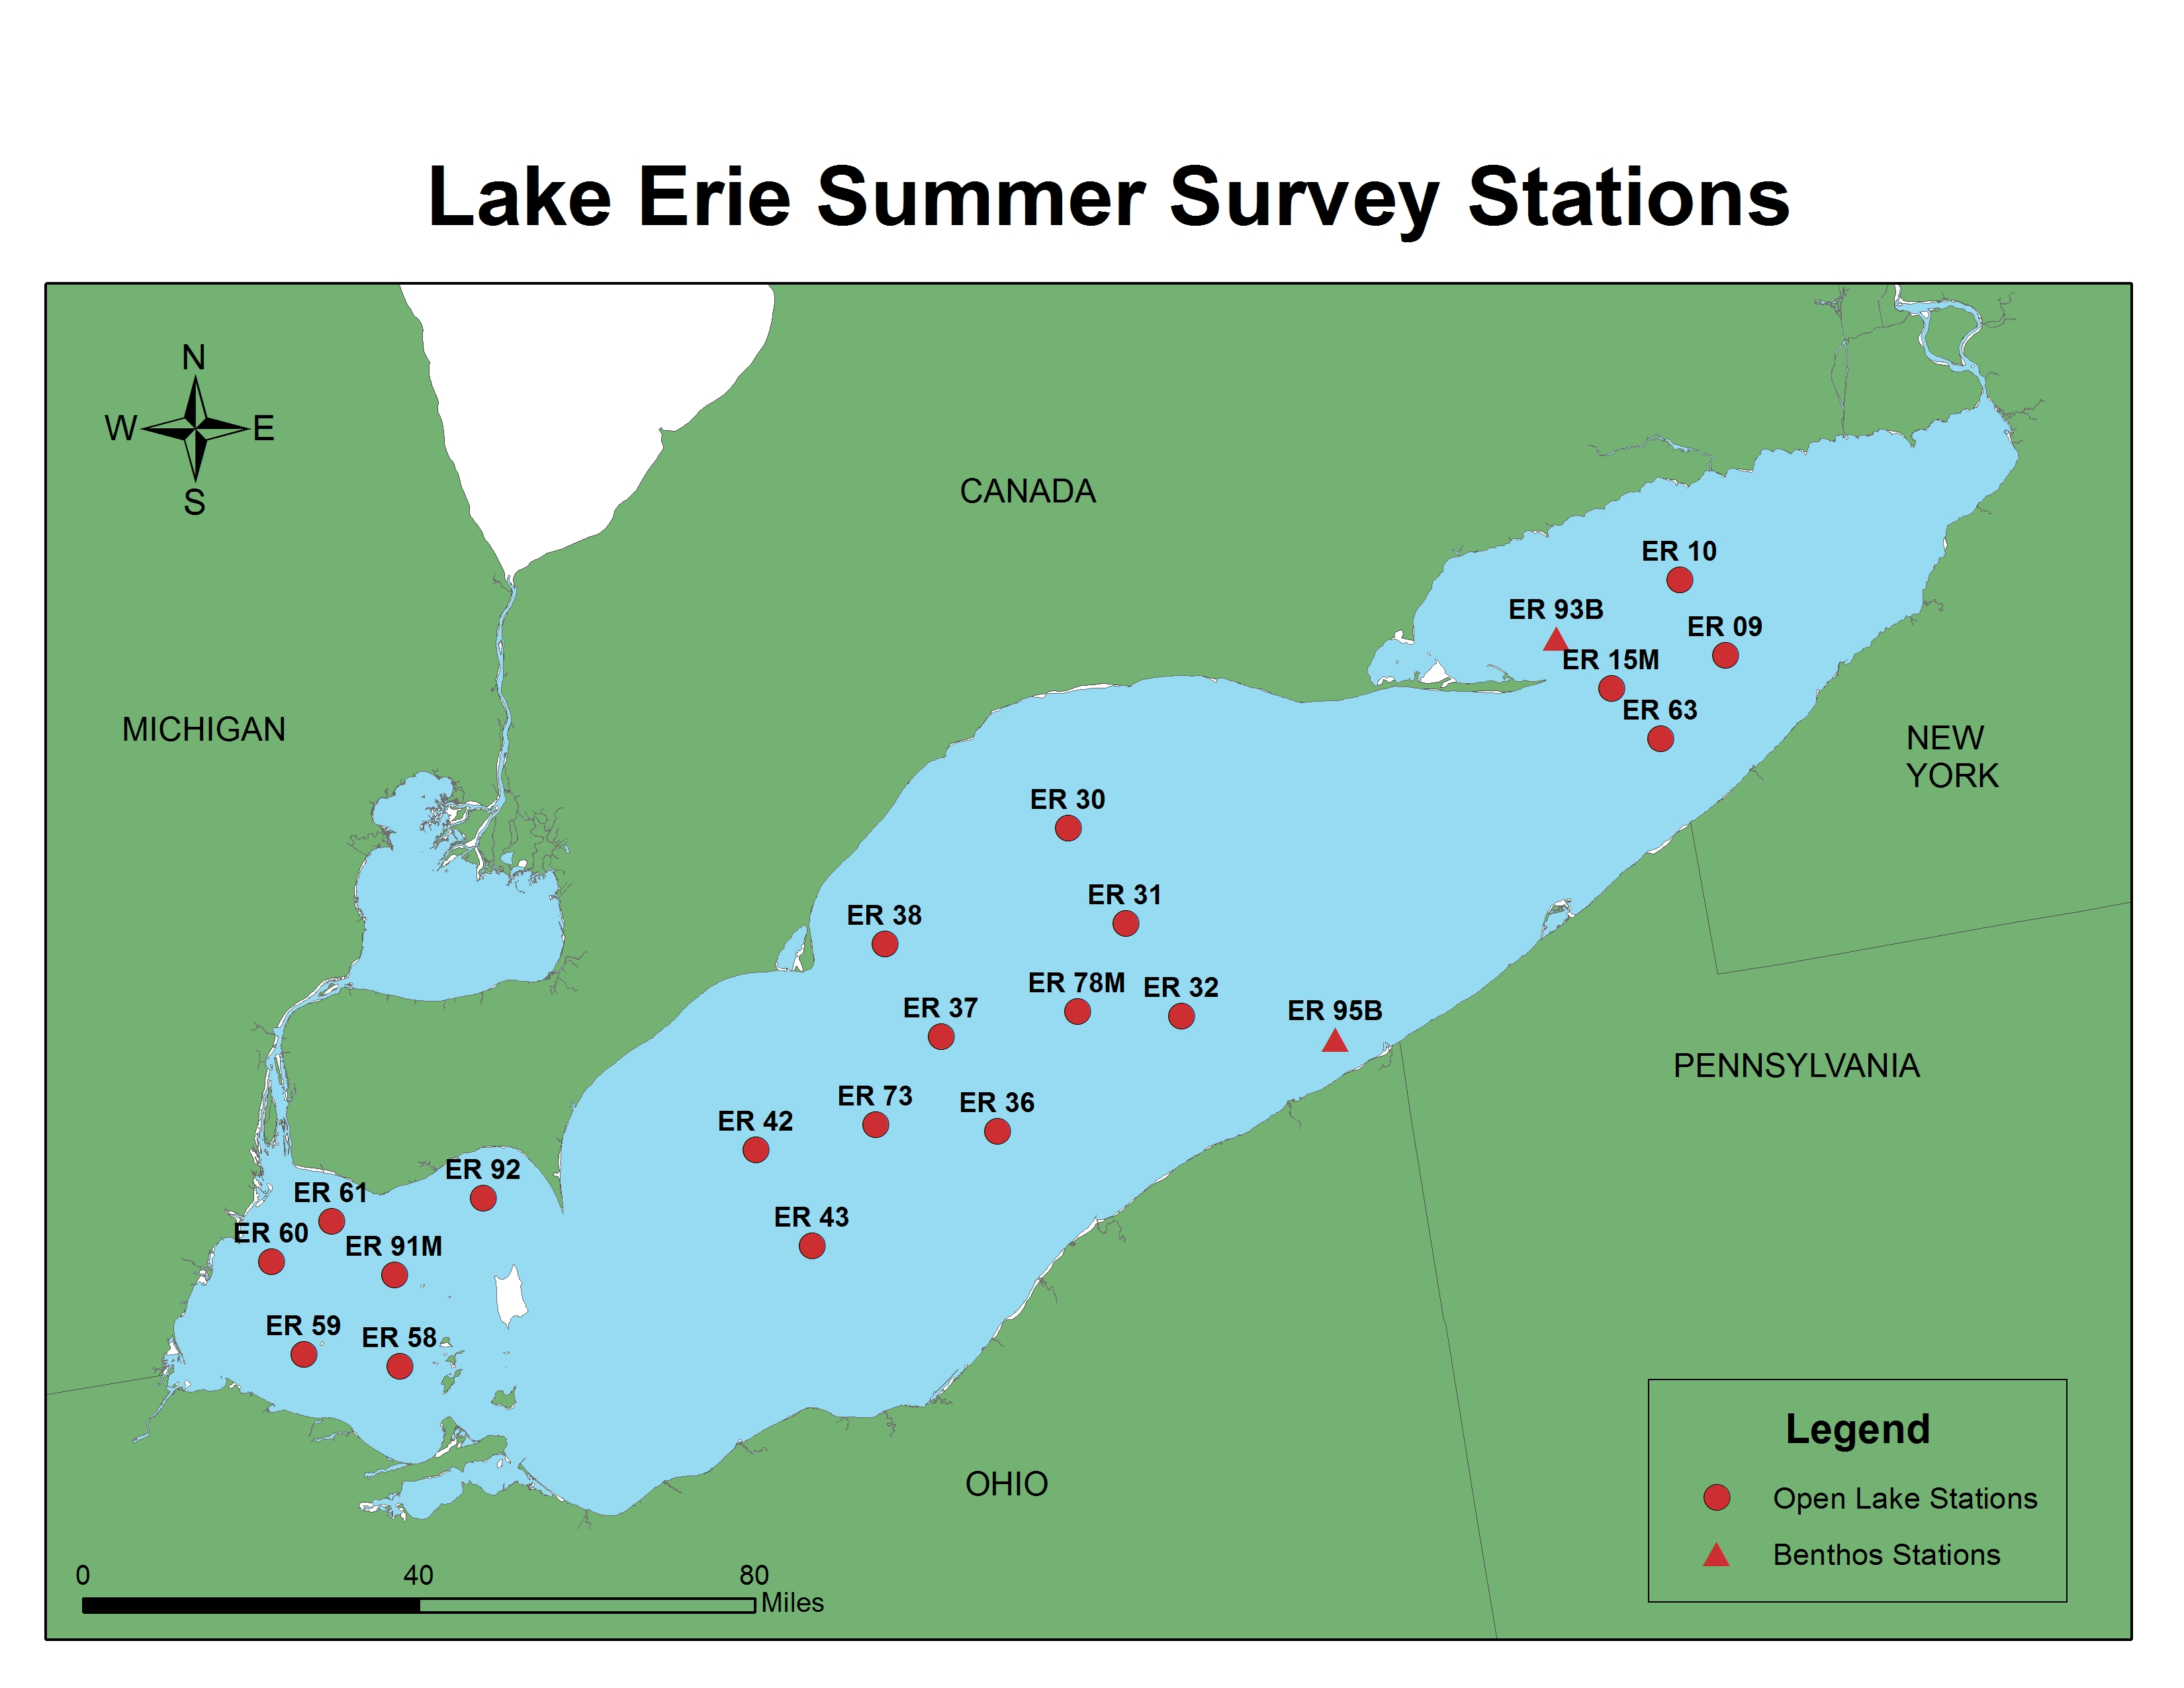

In [2]:
from IPython.display import Image
Image(filename='../../measurements/GLNPO/Erie_Summer_Survey2017.jpg') 

In [3]:
eastern_basin = ['ER15M', 'ER09', 'ER63', 'ER10']
central_basin = ['ER78M', 'ER38', 'ER37', 'ER42', 'ER30', 'ER73', 'ER36', 'ER32'] #, 'ER43','ER31']
western_basin = ['ER58', 'ER59', 'ER61', 'ER60', 'ER92', 'ER91M']

In [4]:
stations = eastern_basin + central_basin + western_basin
years = range(2003,2018)
seasons = ['Spring', 'Summer']

In [5]:
import numpy as np
from scipy import interpolate
import statsmodels.api as sm


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
Cl = pd.read_csv('../../measurements/GLNPO/Mass Balance/Cl.csv')
Cl = Cl[Cl.QC_TYPE=='routine field sample']
Cl = Cl[~Cl.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Cl = Cl[Cl.YEAR>2002]
Cl.loc[:,'SAMPLE_DEPTH_M'] *= -1
Cl.round({'SAMPLE_DEPTH_M': 0})
Cl = Cl[Cl['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Cl = Cl[Cl['SEASON'].isin(seasons)]
Cl['Cl_conc'] = pd.to_numeric(Cl['VALUE_1'], errors='coerce')
# Cl = Cl[Cl['VALUE_1']>50]
# Cl = Cl.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()

In [24]:
Alk = pd.read_csv('../../measurements/GLNPO/Mass Balance/Alk.csv')
Alk = Alk[Alk.QC_TYPE=='routine field sample']
Alk = Alk[~Alk.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Alk = Alk[Alk.YEAR>2002]
Alk.loc[:,'SAMPLE_DEPTH_M'] *= -1
Alk.round({'SAMPLE_DEPTH_M': 0})
Alk = Alk[Alk['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Alk = Alk[Alk['SEASON'].isin(seasons)]
Alk['Alk_conc'] = pd.to_numeric(Alk['VALUE_1'], errors='coerce')
# Alk = Alk[Alk['VALUE_1']>50]
# Alk = Alk.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()

In [27]:
Ratios = pd.merge(Cl, Alk, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])

In [33]:
Ratios['AlkVsCl'] = Ratios['Alk_conc']/Ratios['Cl_conc']

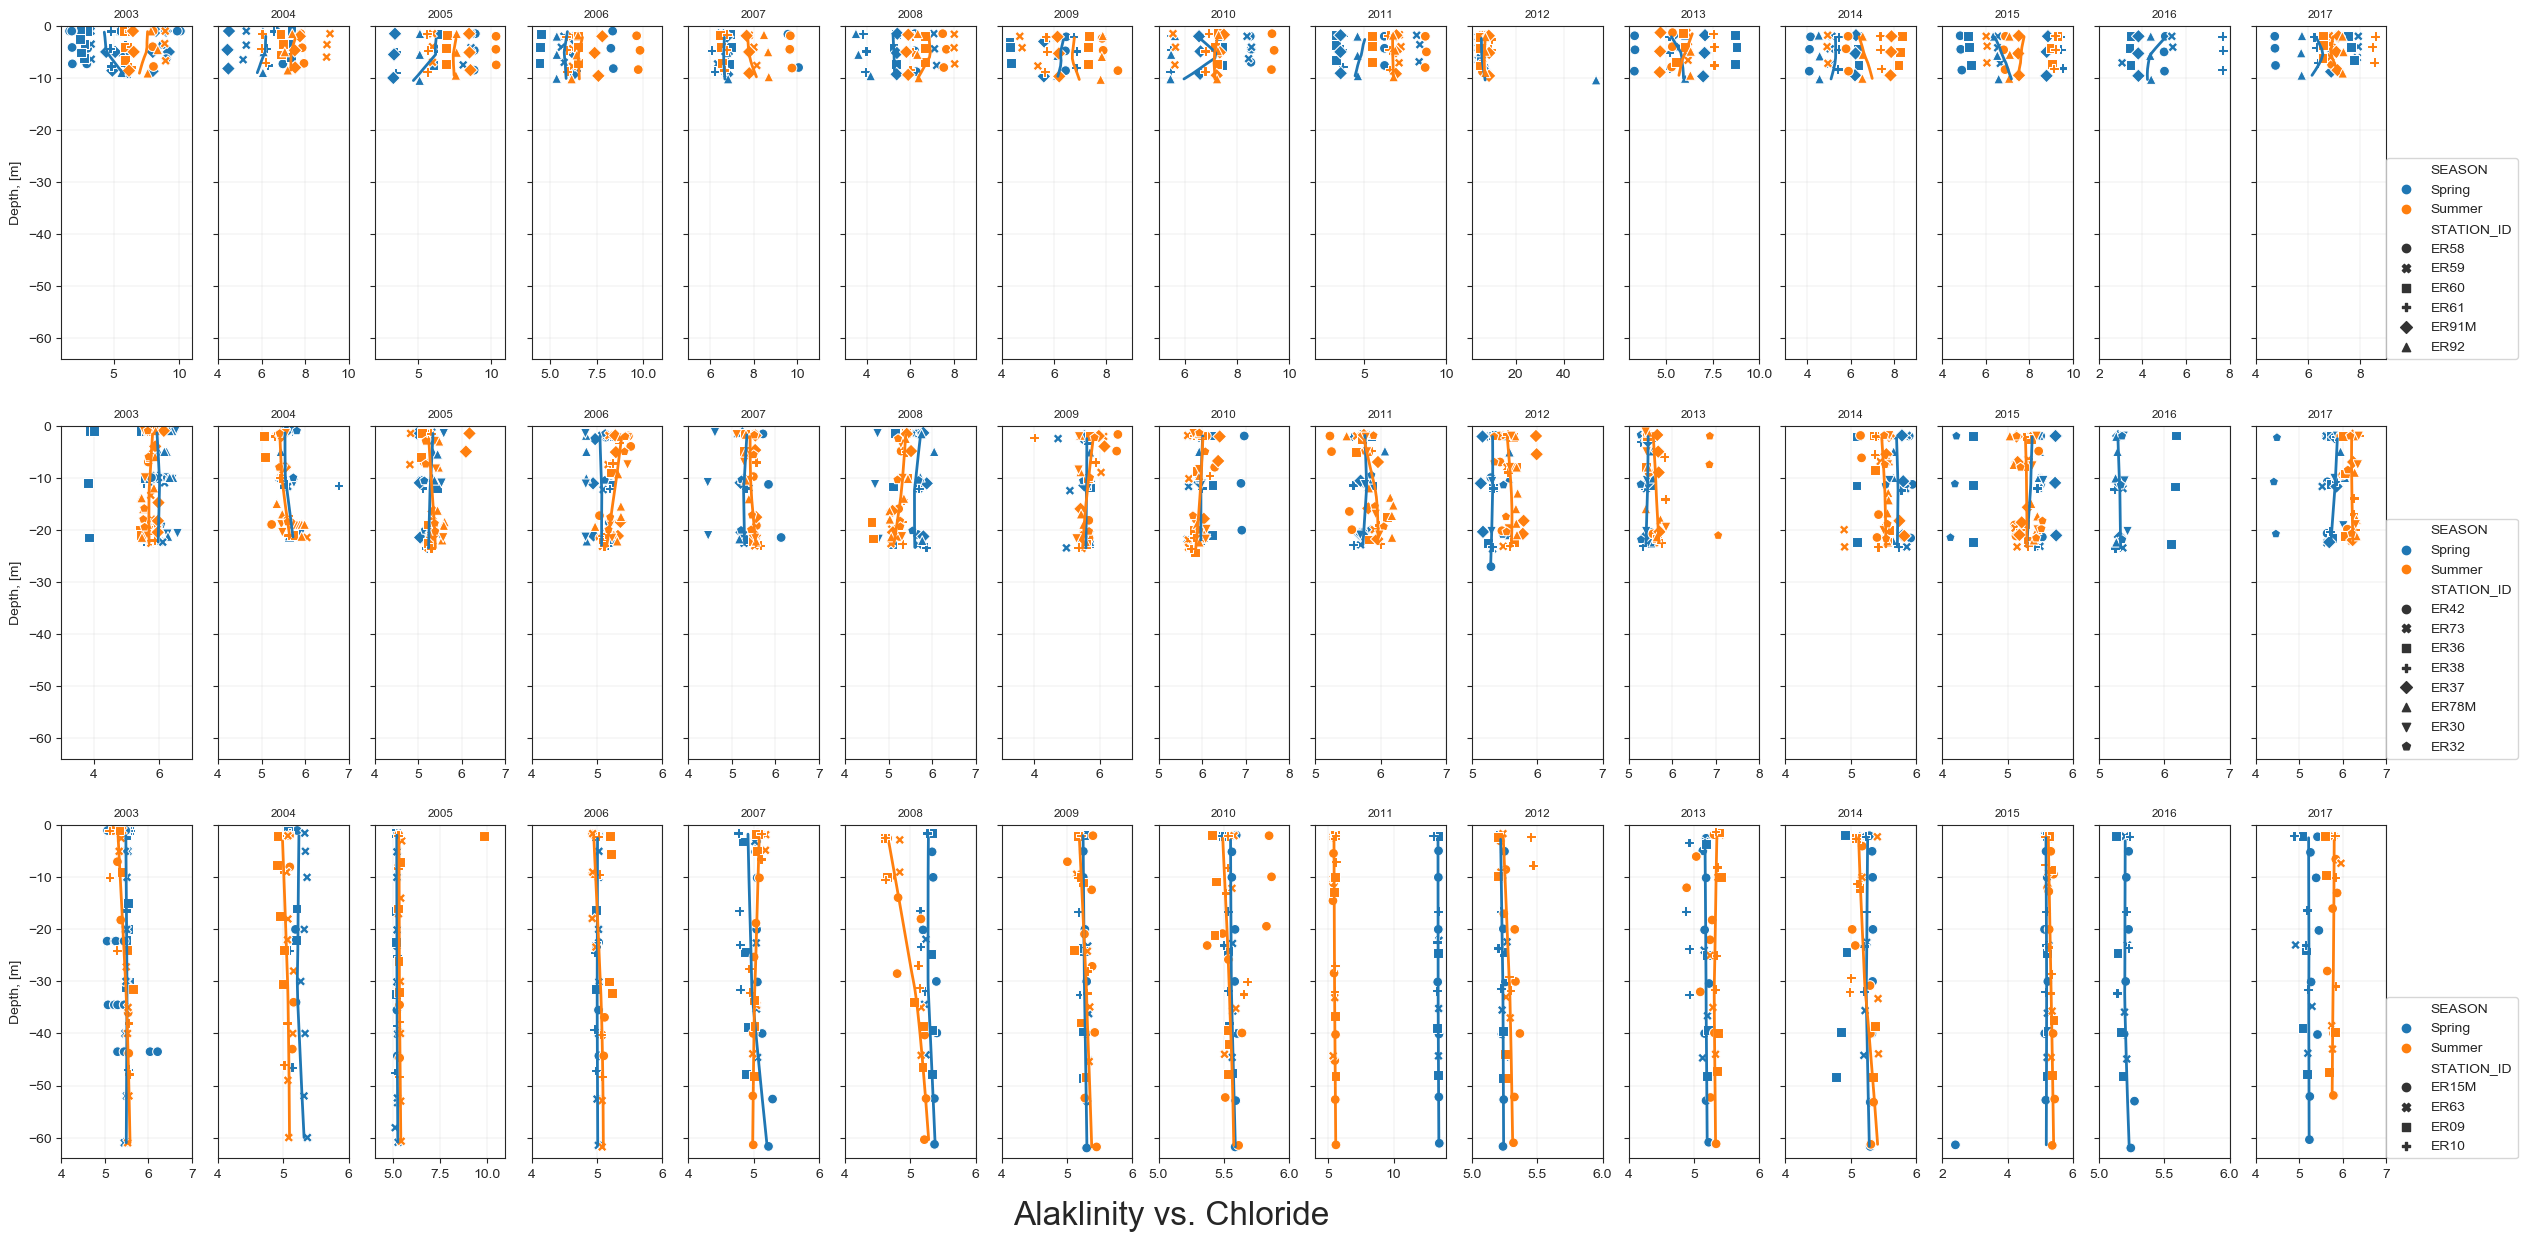

In [44]:
# %matplotlib osx
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Ratios[(Ratios['STATION_ID'].isin(b)) & (Ratios['YEAR']==y)]
        sns.scatterplot(x='AlkVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['AlkVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['AlkVsCl'].reset_index()['AlkVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((np.floor(min(low)),np.ceil(max(high))))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Alaklinity vs. Chloride', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/AlkVaCl_no_scale.pdf')




In [45]:
pH = pd.read_csv('../../measurements/GLNPO/Mass Balance/pH.csv')
pH = pH[pH.QC_TYPE=='routine field sample']
pH = pH[~pH.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
pH = pH[pH.YEAR>2002]
pH.loc[:,'SAMPLE_DEPTH_M'] *= -1
pH.round({'SAMPLE_DEPTH_M': 0})
pH = pH[pH['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
pH = pH[pH['SEASON'].isin(seasons)]
pH['pH_conc'] = pd.to_numeric(pH['VALUE_1'], errors='coerce')
# pH = pH[pH['VALUE_1']>50]
# pH = pH.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()

In [46]:
pHVsCl = pd.merge(Cl, pH, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
pHVsCl['pHVsCl'] = pHVsCl['pH_conc']/pHVsCl['Cl_conc']

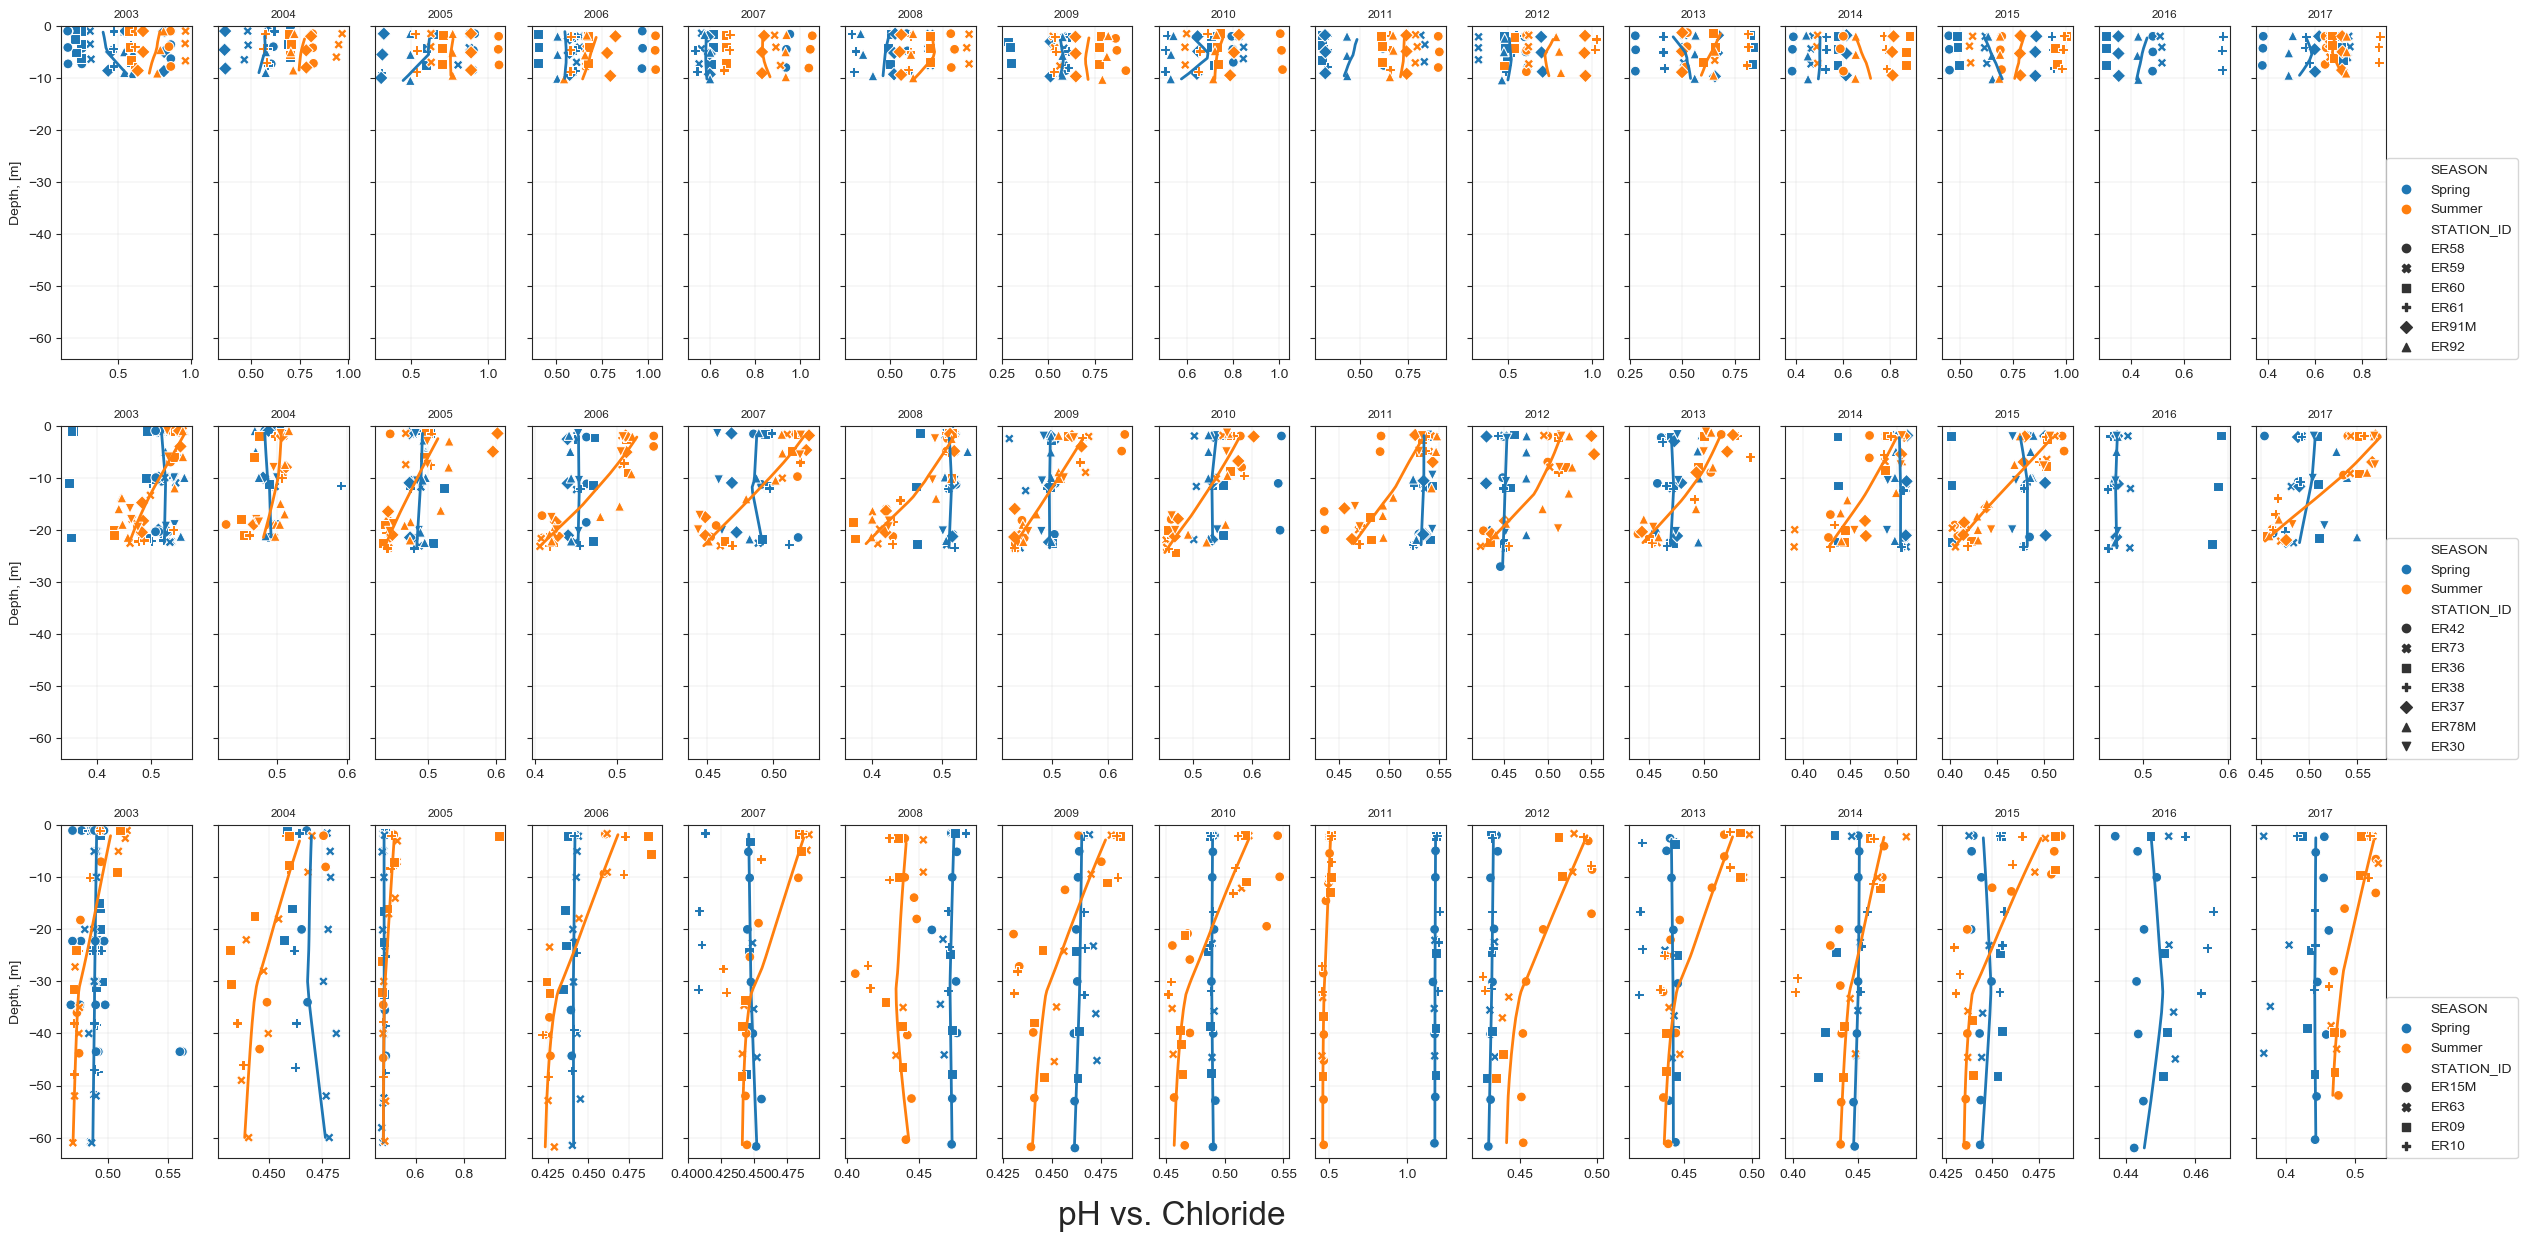

In [73]:
# %matplotlib osx
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = pHVsCl[(pHVsCl['STATION_ID'].isin(b)) & (pHVsCl['YEAR']==y)]
        sns.scatterplot(x='pHVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['pHVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['pHVsCl'].reset_index()['pHVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'pH vs. Chloride', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/pH_vs_Cl_no_scale.pdf')




In [68]:
TOTP = pd.read_csv('../../measurements/GLNPO/Mass Balance/TOTP.csv')
TOTP = TOTP[TOTP.QC_TYPE=='routine field sample']
TOTP = TOTP[~TOTP.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
TOTP = TOTP[TOTP.YEAR>2002]
TOTP.loc[:,'SAMPLE_DEPTH_M'] *= -1
TOTP.round({'SAMPLE_DEPTH_M': 0})
TOTP = TOTP[TOTP['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
TOTP = TOTP[TOTP['SEASON'].isin(seasons)]
TOTP['TOTP_conc'] = pd.to_numeric(TOTP['VALUE_1'], errors='coerce')
# TOTP = TOTP[TOTP['VALUE_1']>50]
# TOTP = TOTP.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
TOTPVsCl = pd.merge(Cl, TOTP, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
TOTPVsCl['TOTPVsCl'] = TOTPVsCl['TOTP_conc']/TOTPVsCl['Cl_conc']
TOTPVsCl.dropna(subset=['TOTPVsCl'], inplace=True)

Text(8.5,-0.2,'TOTP vs. Chloride, [$\\mu g$ $mg^{-1}$]')

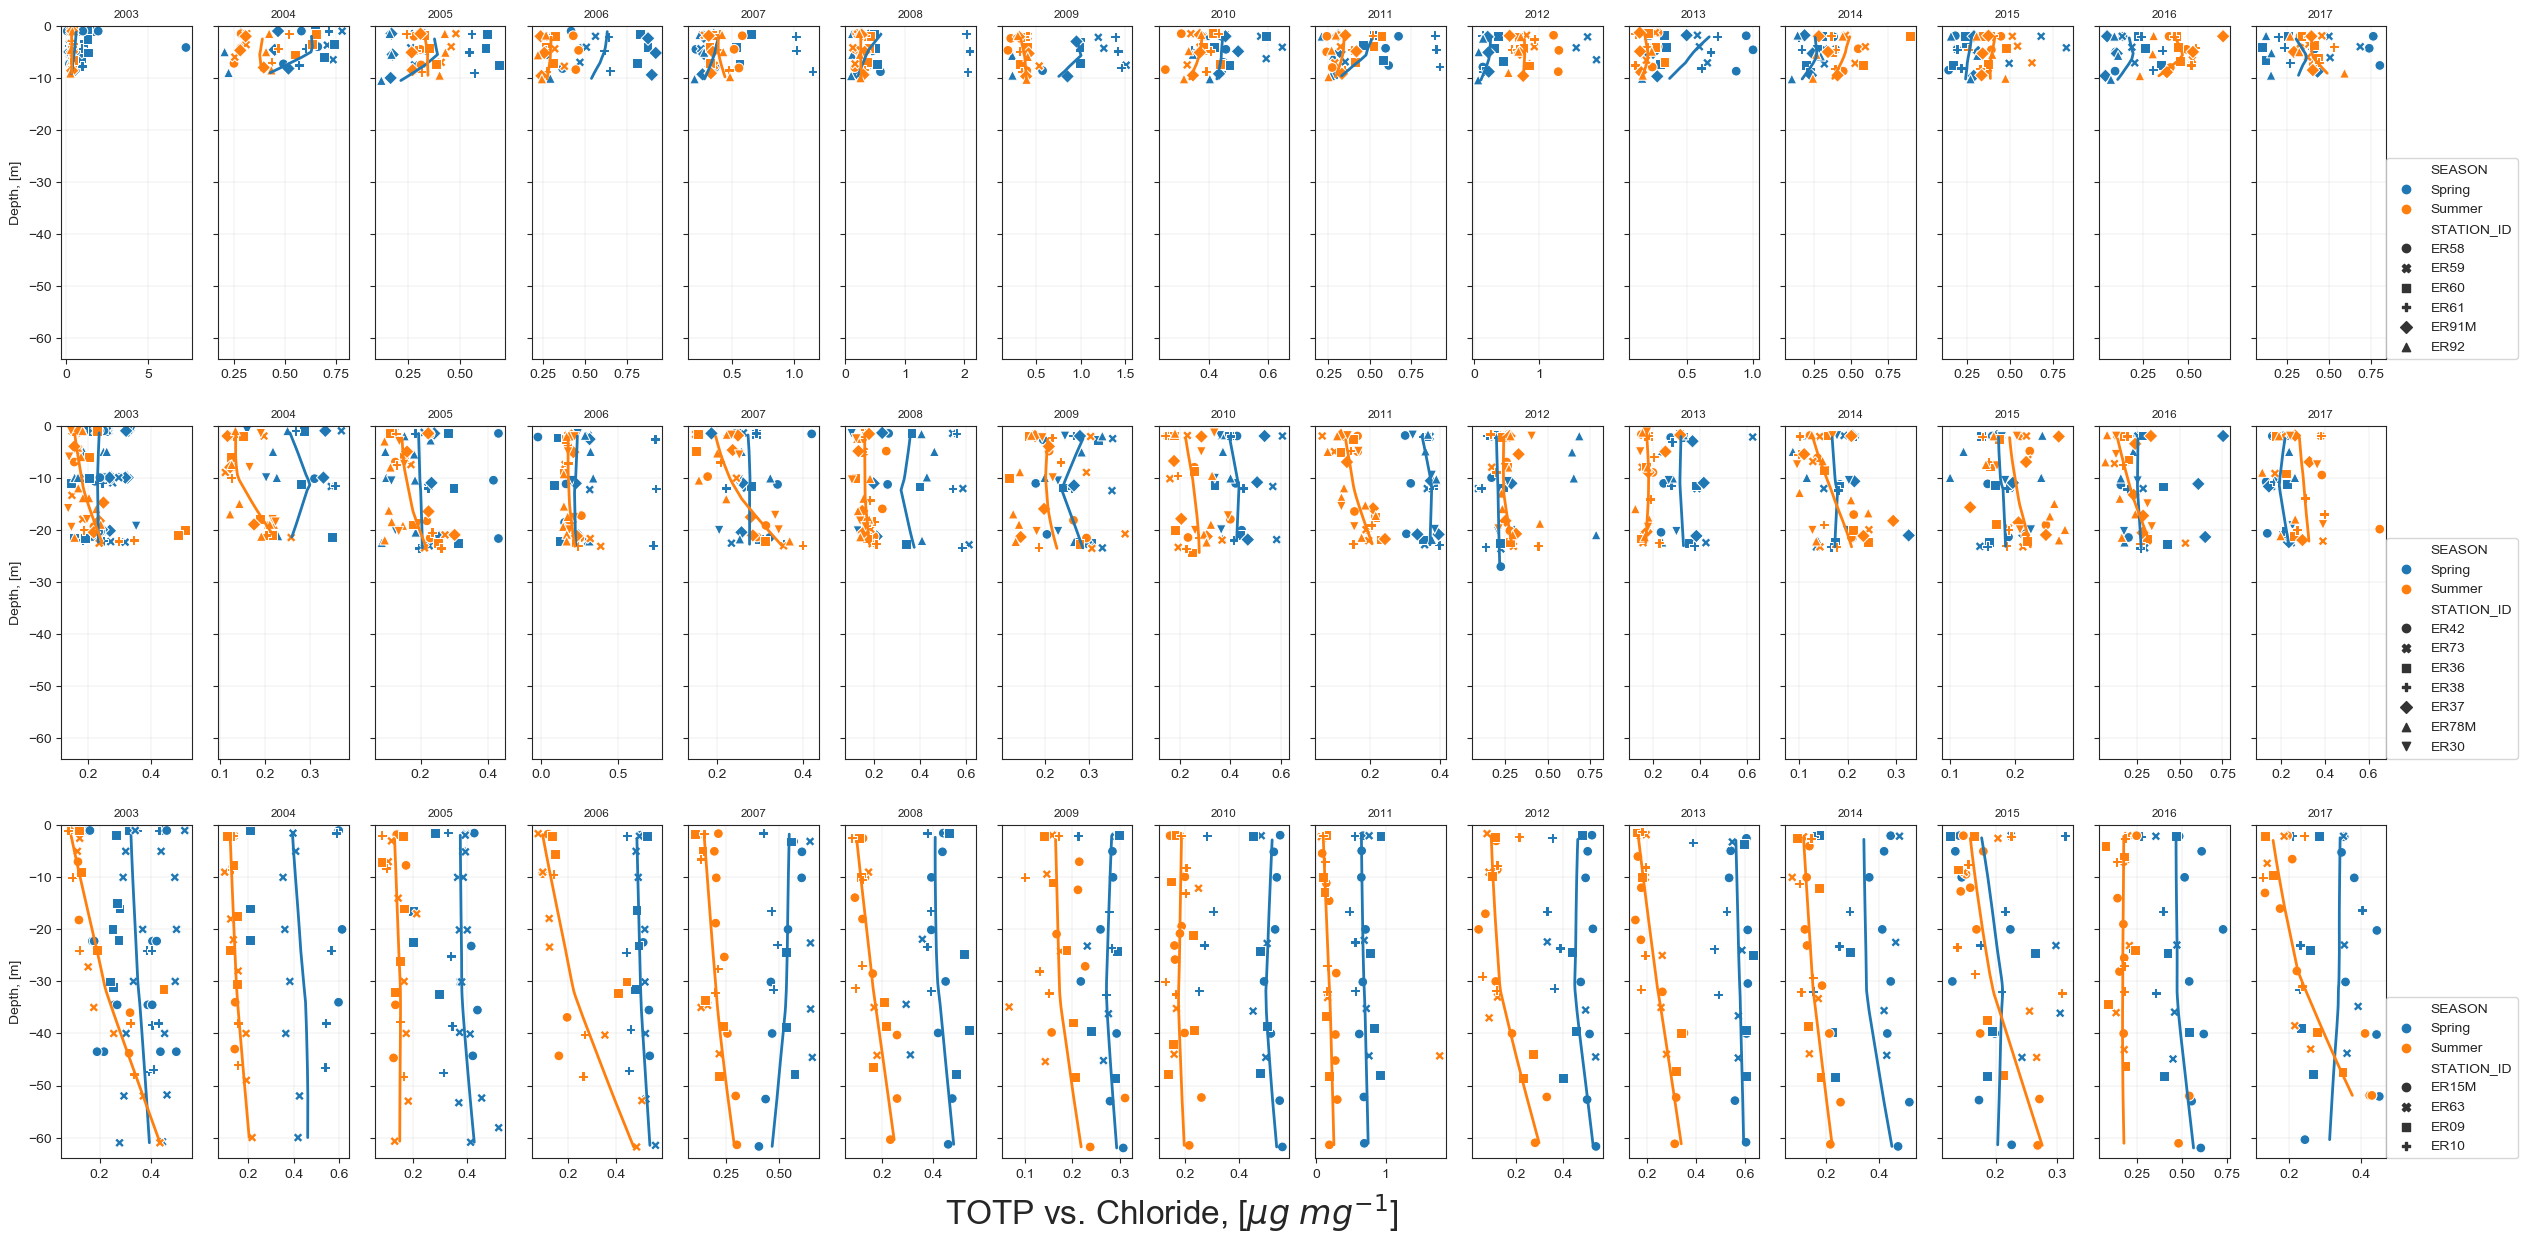

In [80]:

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = TOTPVsCl[(TOTPVsCl['STATION_ID'].isin(b)) & (TOTPVsCl['YEAR']==y)]
        sns.scatterplot(x='TOTPVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['TOTPVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['TOTPVsCl'].reset_index()['TOTPVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'TOTP vs. Chloride, [$\mu g$ $mg^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/TOTP_vs_Cl.pdf')




No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


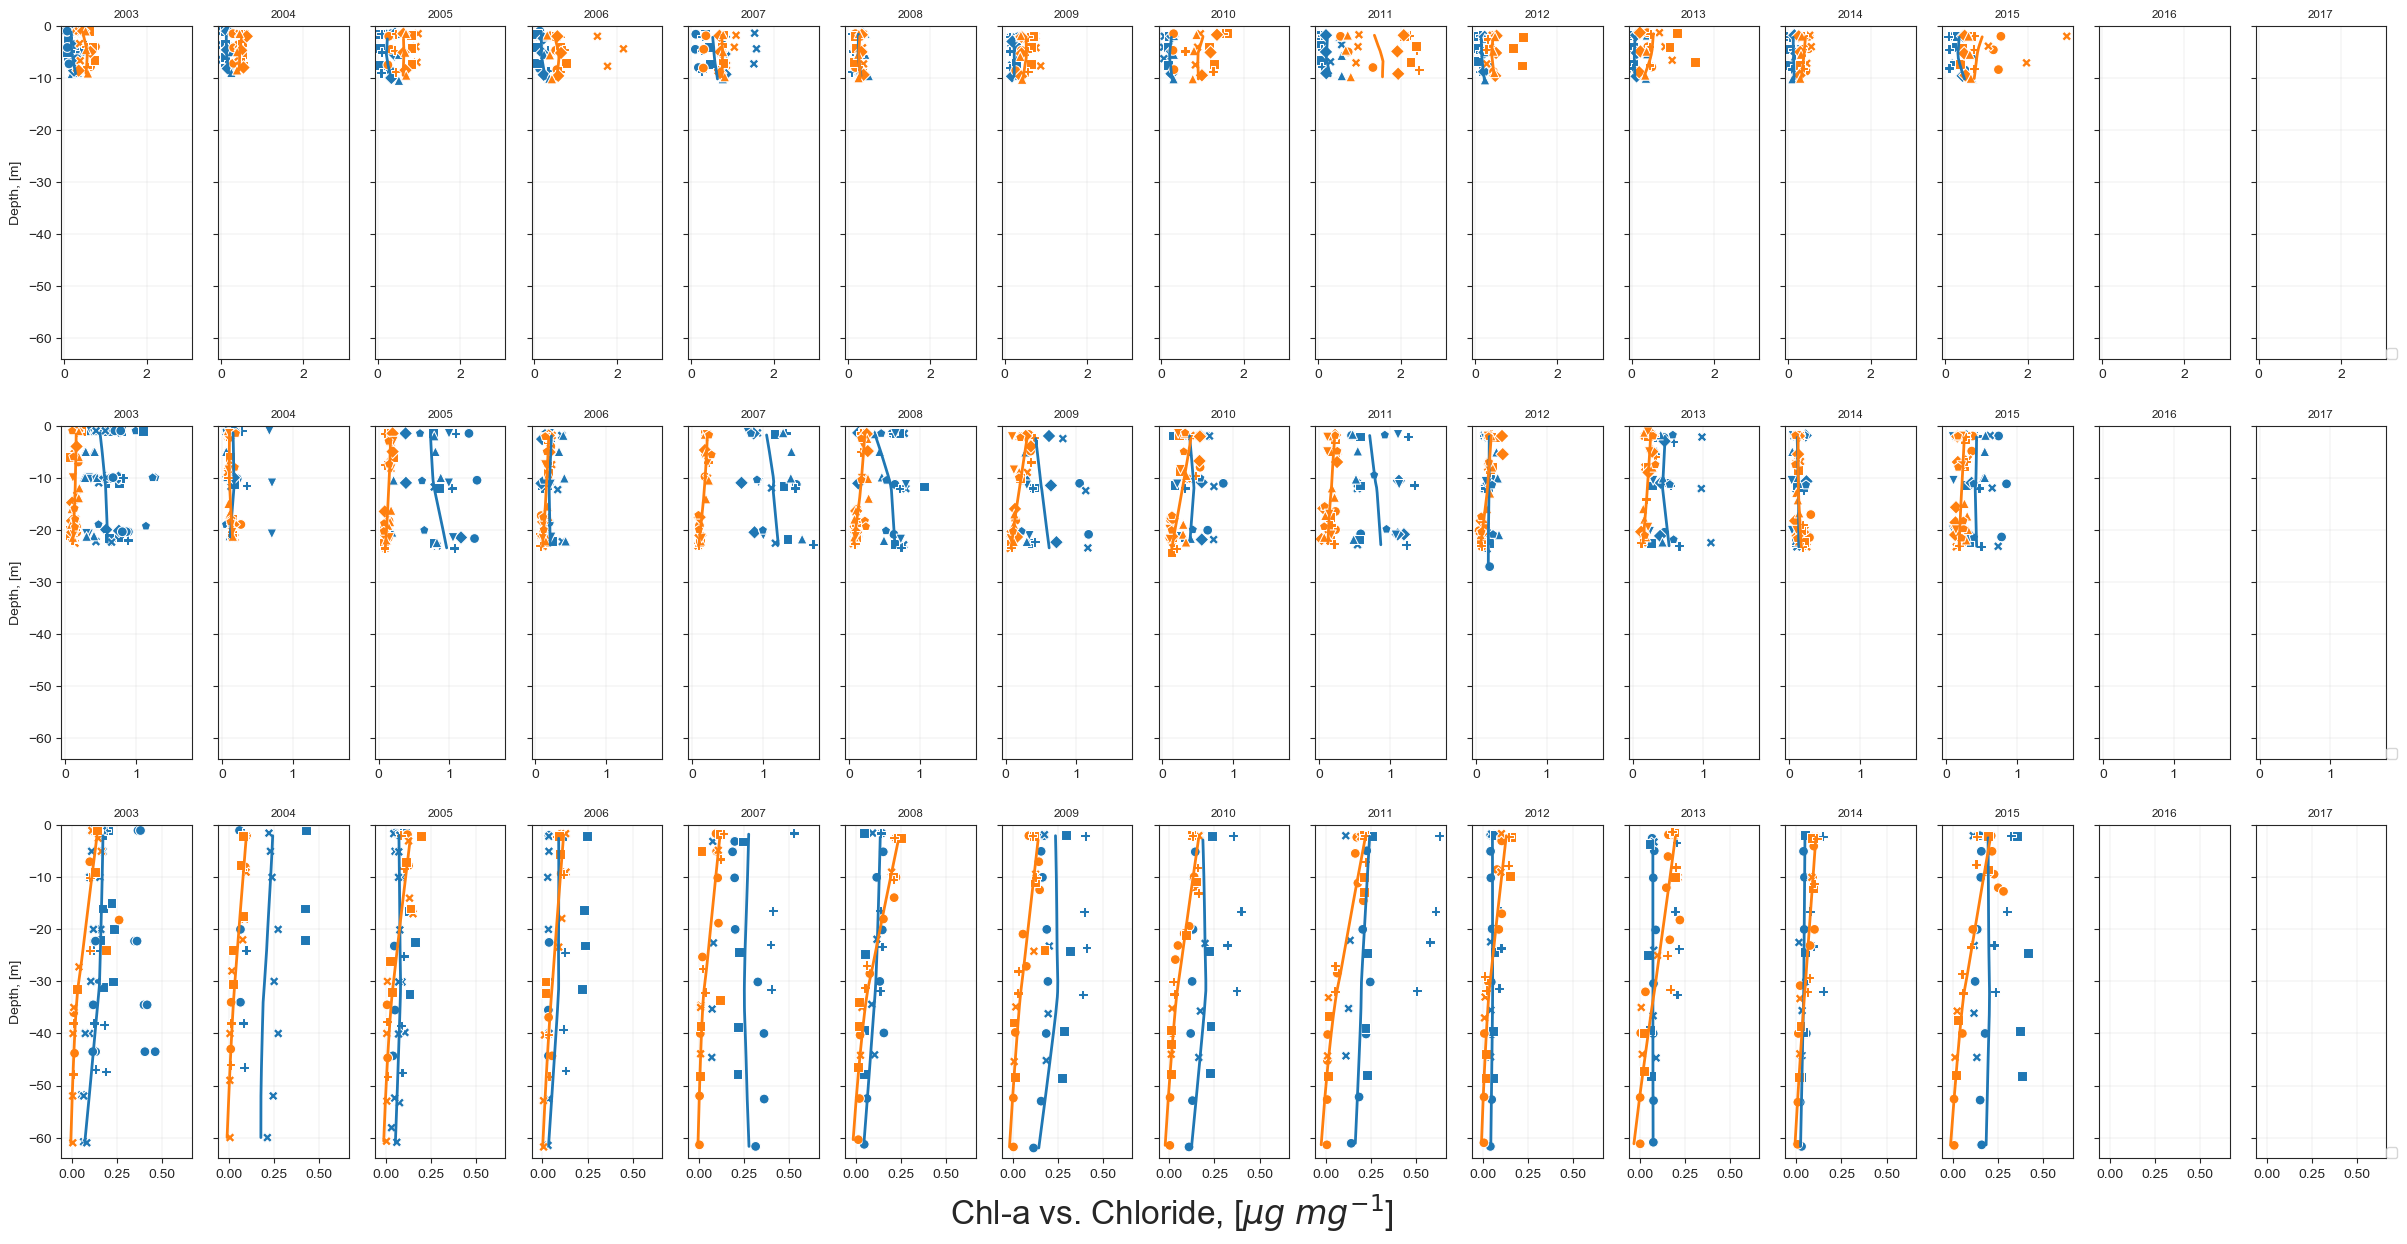

In [110]:
Chla = pd.read_csv('../../measurements/GLNPO/Mass Balance/Chla.csv')
Chla = Chla[Chla.QC_TYPE=='routine field sample']
Chla = Chla[~Chla.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Chla = Chla[Chla.YEAR>2002]
Chla.loc[:,'SAMPLE_DEPTH_M'] *= -1
Chla.round({'SAMPLE_DEPTH_M': 0})
Chla = Chla[Chla['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Chla = Chla[Chla['SEASON'].isin(seasons)]
Chla['Chla_conc'] = pd.to_numeric(Chla['VALUE_1'], errors='coerce')
# Chla = Chla[Chla['VALUE_1']>50]
# Chla = Chla.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
ChlaVsCl = pd.merge(Cl, Chla, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
ChlaVsCl['ChlaVsCl'] = ChlaVsCl['Chla_conc']/ChlaVsCl['Cl_conc']
ChlaVsCl.dropna(subset=['ChlaVsCl'], inplace=True)
# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = ChlaVsCl[(ChlaVsCl['STATION_ID'].isin(b)) & (ChlaVsCl['YEAR']==y)]
        sns.scatterplot(x='ChlaVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsCl'].reset_index()['ChlaVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((min(low), max(high)))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Chl-a vs. Chloride, [$\mu g$ $mg^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Chla_vs_Cl.pdf')




In [133]:
Ntot_oxidized = pd.read_csv('../../measurements/GLNPO/Mass Balance/Ntot_oxidized.csv')
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized.QC_TYPE=='routine field sample']
Ntot_oxidized = Ntot_oxidized[~Ntot_oxidized.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized.YEAR>2002]
Ntot_oxidized.loc[:,'SAMPLE_DEPTH_M'] *= -1
Ntot_oxidized.round({'SAMPLE_DEPTH_M': 0})
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['SEASON'].isin(seasons)]
Ntot_oxidized['Ntot_oxidized_conc'] = pd.to_numeric(Ntot_oxidized['VALUE_1'], errors='coerce')
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['Ntot_oxidized_conc']>0]
# Ntot_oxidized = Ntot_oxidized.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
Ntot_oxidizedVsCl = pd.merge(Cl, Ntot_oxidized, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
Ntot_oxidizedVsCl['Ntot_oxidizedVsCl'] = Ntot_oxidizedVsCl['Ntot_oxidized_conc']/Ntot_oxidizedVsCl['Cl_conc']*1000
Ntot_oxidizedVsCl.dropna(subset=['Ntot_oxidizedVsCl'], inplace=True)

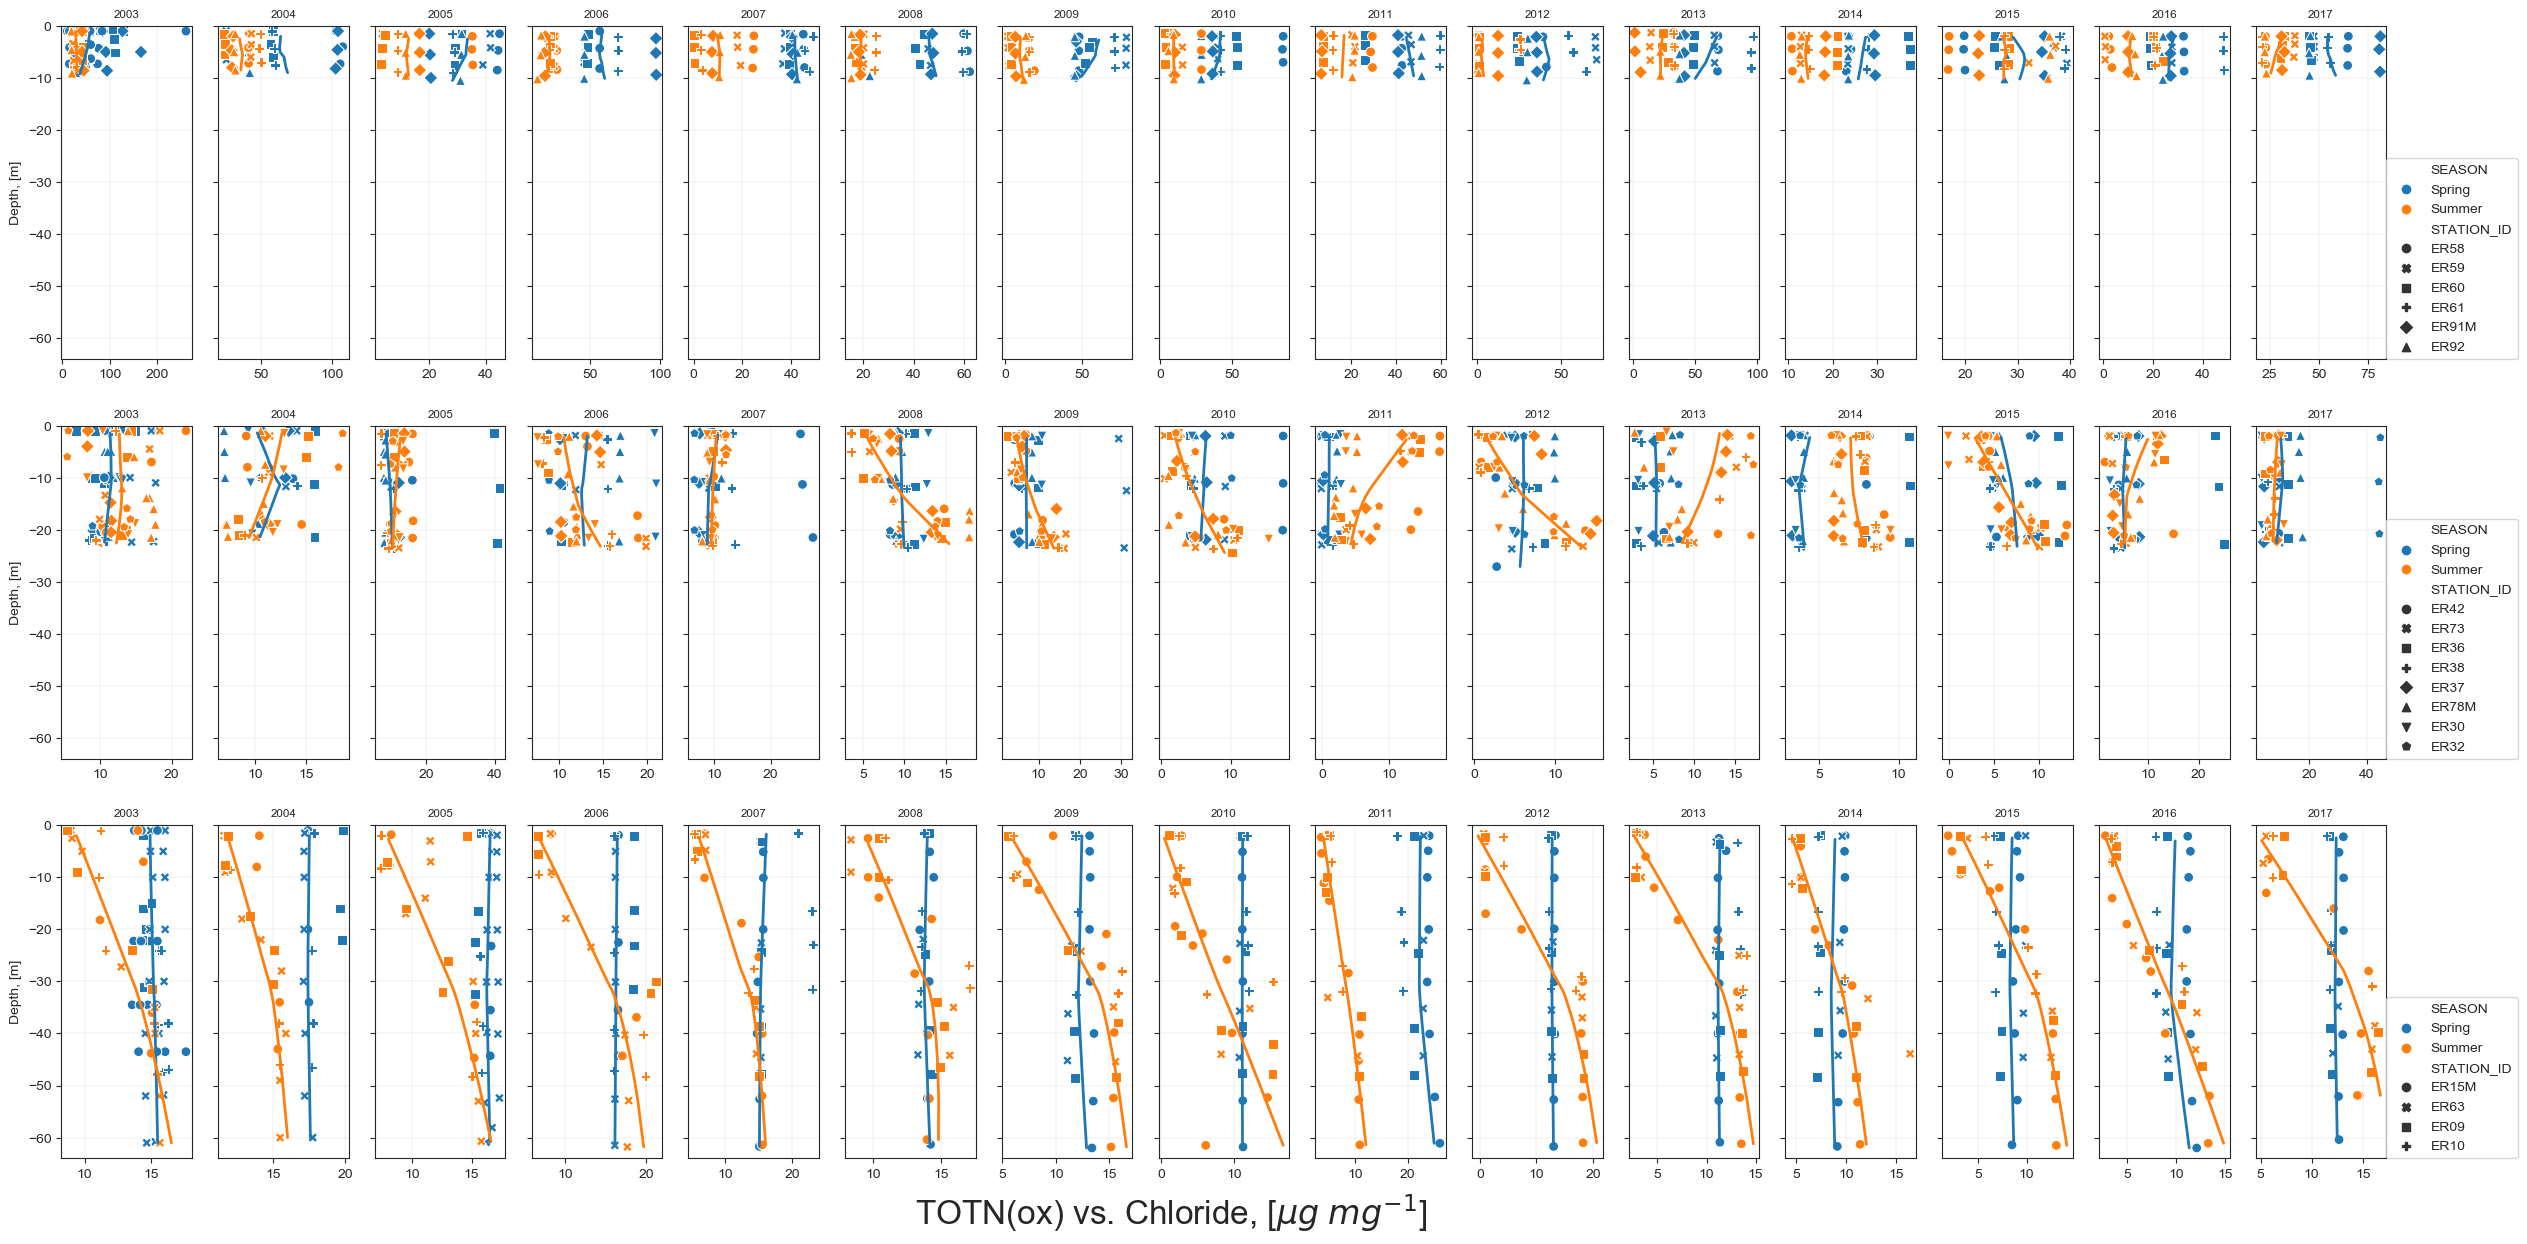

In [84]:

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Ntot_oxidizedVsCl[(Ntot_oxidizedVsCl['STATION_ID'].isin(b)) & (Ntot_oxidizedVsCl['YEAR']==y)]
        sns.scatterplot(x='Ntot_oxidizedVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['Ntot_oxidizedVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['Ntot_oxidizedVsCl'].reset_index()['Ntot_oxidizedVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'TOTN(ox) vs. Chloride, [$\mu g$ $mg^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Ntot_oxidized_vs_Cl_no_scale.pdf')




In [87]:
orthoP = pd.read_csv('../../measurements/GLNPO/Mass Balance/orthoP.csv')
orthoP = orthoP[orthoP.QC_TYPE=='routine field sample']
orthoP = orthoP[~orthoP.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
orthoP = orthoP[orthoP.YEAR>2002]
orthoP.loc[:,'SAMPLE_DEPTH_M'] *= -1
orthoP.round({'SAMPLE_DEPTH_M': 0})
orthoP = orthoP[orthoP['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
orthoP = orthoP[orthoP['SEASON'].isin(seasons)]
orthoP['orthoP_conc'] = pd.to_numeric(orthoP['VALUE_1'], errors='coerce')
# orthoP = orthoP[orthoP['VALUE_1']>50]
# orthoP = orthoP.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
orthoPVsCl = pd.merge(Cl, orthoP, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
orthoPVsCl['orthoPVsCl'] = orthoPVsCl['orthoP_conc']/orthoPVsCl['Cl_conc']
orthoPVsCl.dropna(subset=['orthoPVsCl'], inplace=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Text(8.5,-0.2,'Inorg. P vs. Chloride, [$\\mu g$ $mg^{-1}$]')

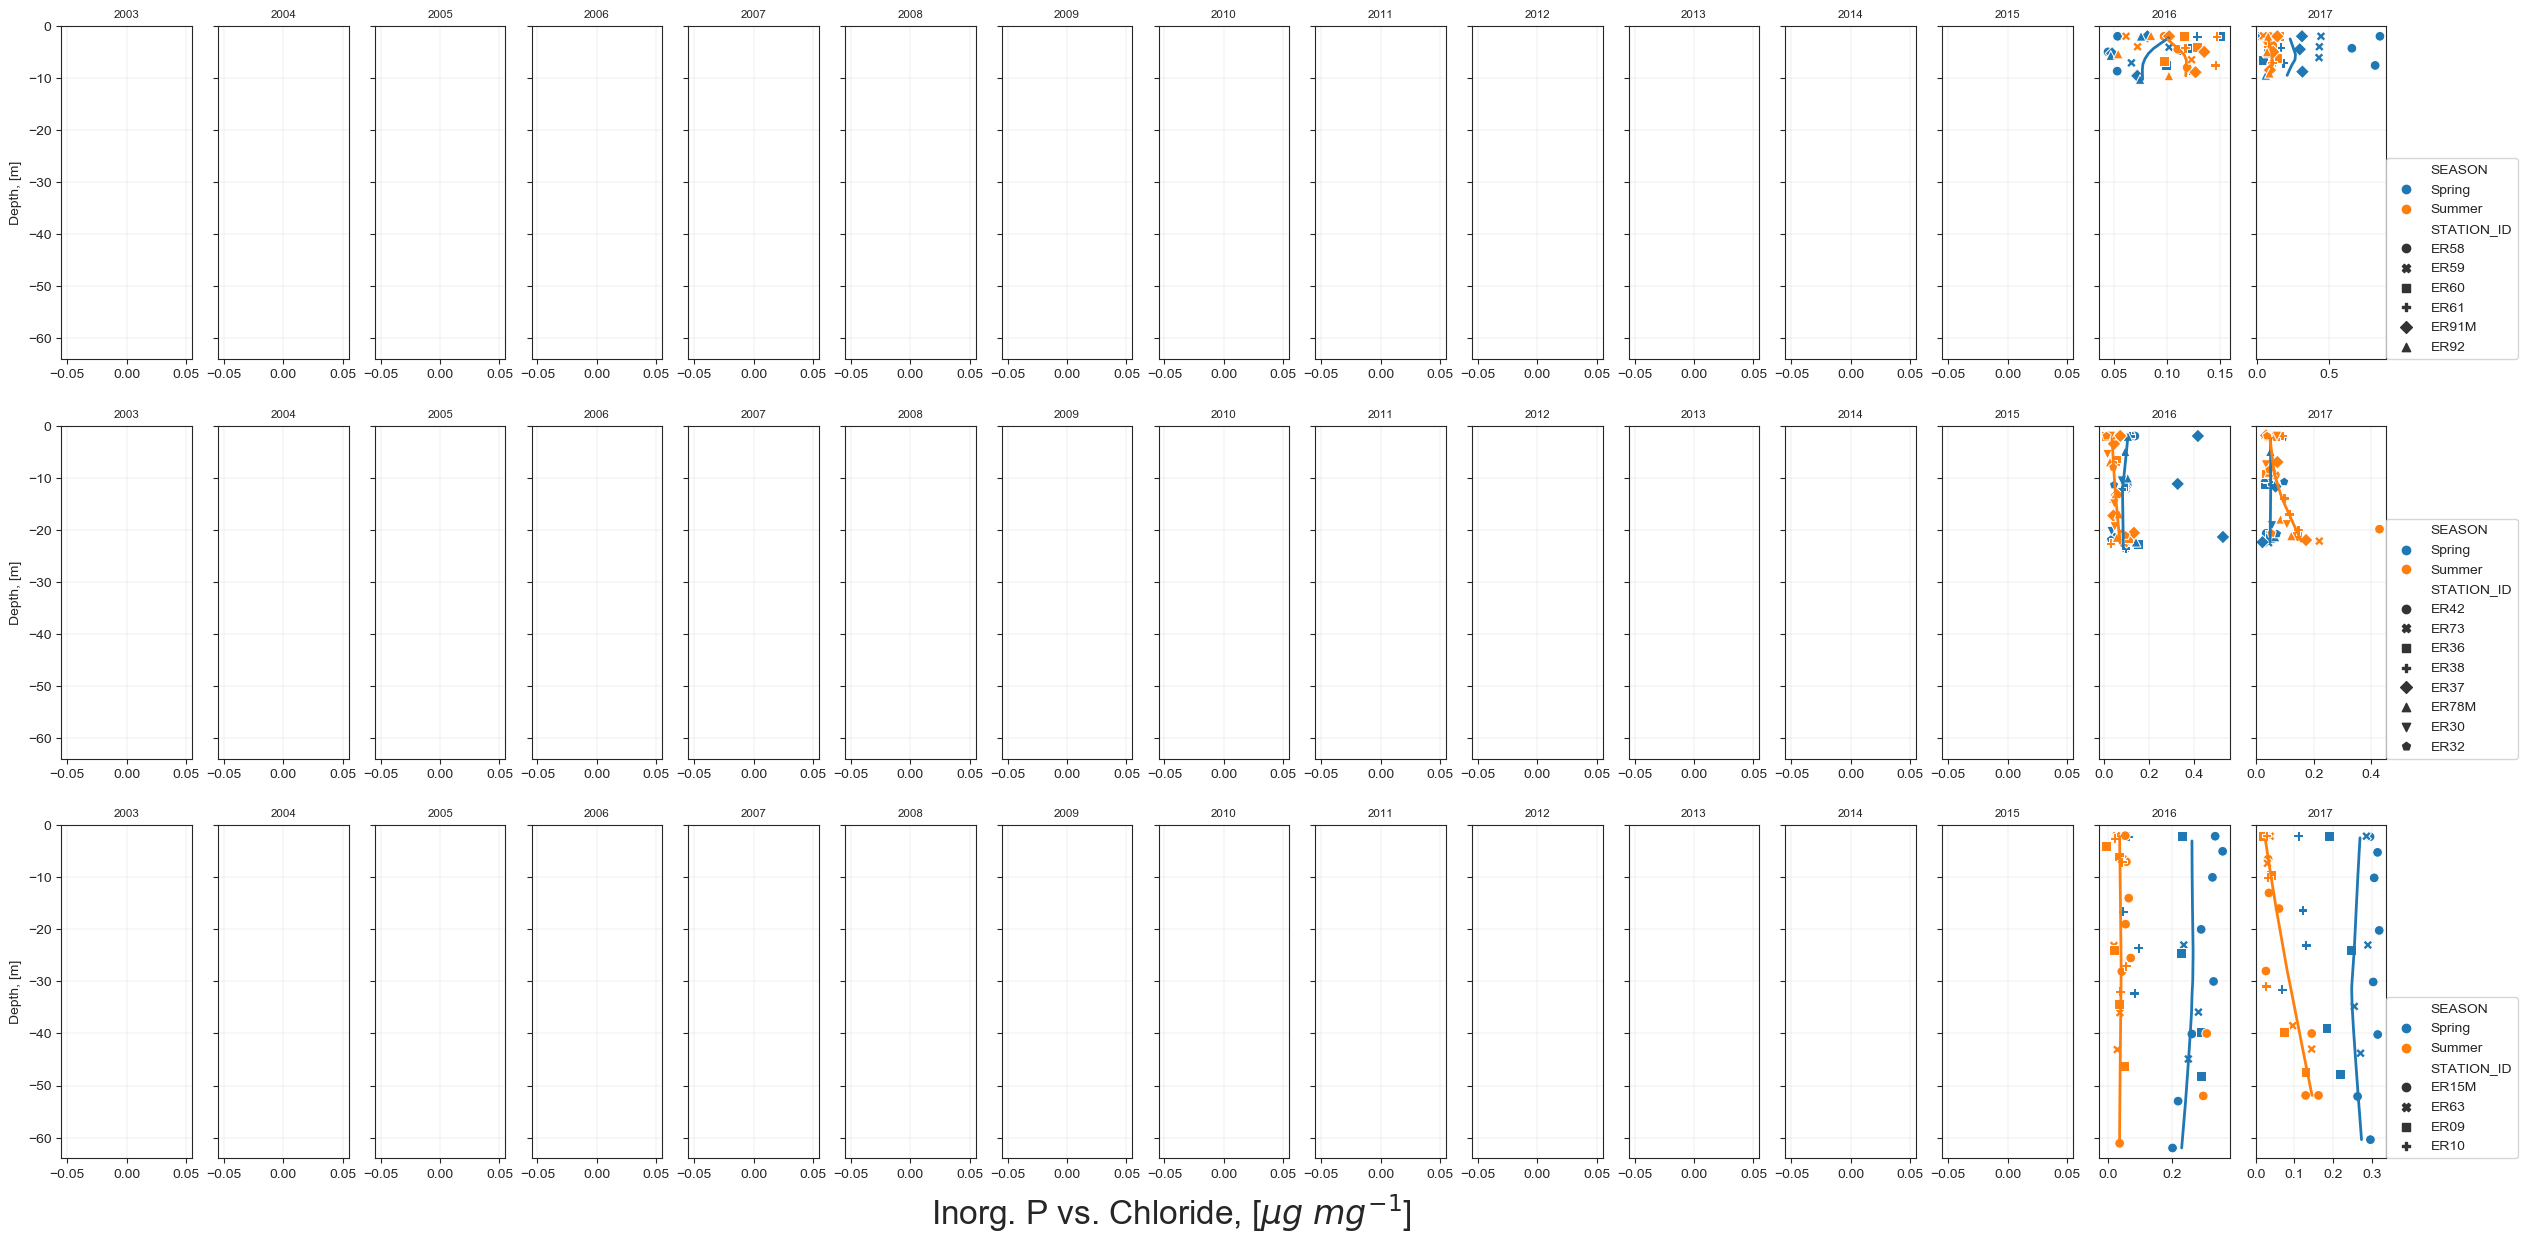

In [91]:

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = orthoPVsCl[(orthoPVsCl['STATION_ID'].isin(b)) & (orthoPVsCl['YEAR']==y)]
        sns.scatterplot(x='orthoPVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['orthoPVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['orthoPVsCl'].reset_index()['orthoPVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Inorg. P vs. Chloride, [$\mu g$ $mg^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/orthoP_vs_Cl.pdf')




In [92]:
SilicaDissAsSi = pd.read_csv('../../measurements/GLNPO/Mass Balance/SilicaDissAsSi.csv')
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi.QC_TYPE=='routine field sample']
SilicaDissAsSi = SilicaDissAsSi[~SilicaDissAsSi.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi.YEAR>2002]
SilicaDissAsSi.loc[:,'SAMPLE_DEPTH_M'] *= -1
SilicaDissAsSi.round({'SAMPLE_DEPTH_M': 0})
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['SEASON'].isin(seasons)]
SilicaDissAsSi['SilicaDissAsSi_conc'] = pd.to_numeric(SilicaDissAsSi['VALUE_1'], errors='coerce')
# SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['VALUE_1']>50]
# SilicaDissAsSi = SilicaDissAsSi.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
SilicaDissAsSiVsCl = pd.merge(Cl, SilicaDissAsSi, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
SilicaDissAsSiVsCl['SilicaDissAsSiVsCl'] = SilicaDissAsSiVsCl['SilicaDissAsSi_conc']/SilicaDissAsSiVsCl['Cl_conc']
SilicaDissAsSiVsCl.dropna(subset=['SilicaDissAsSiVsCl'], inplace=True)

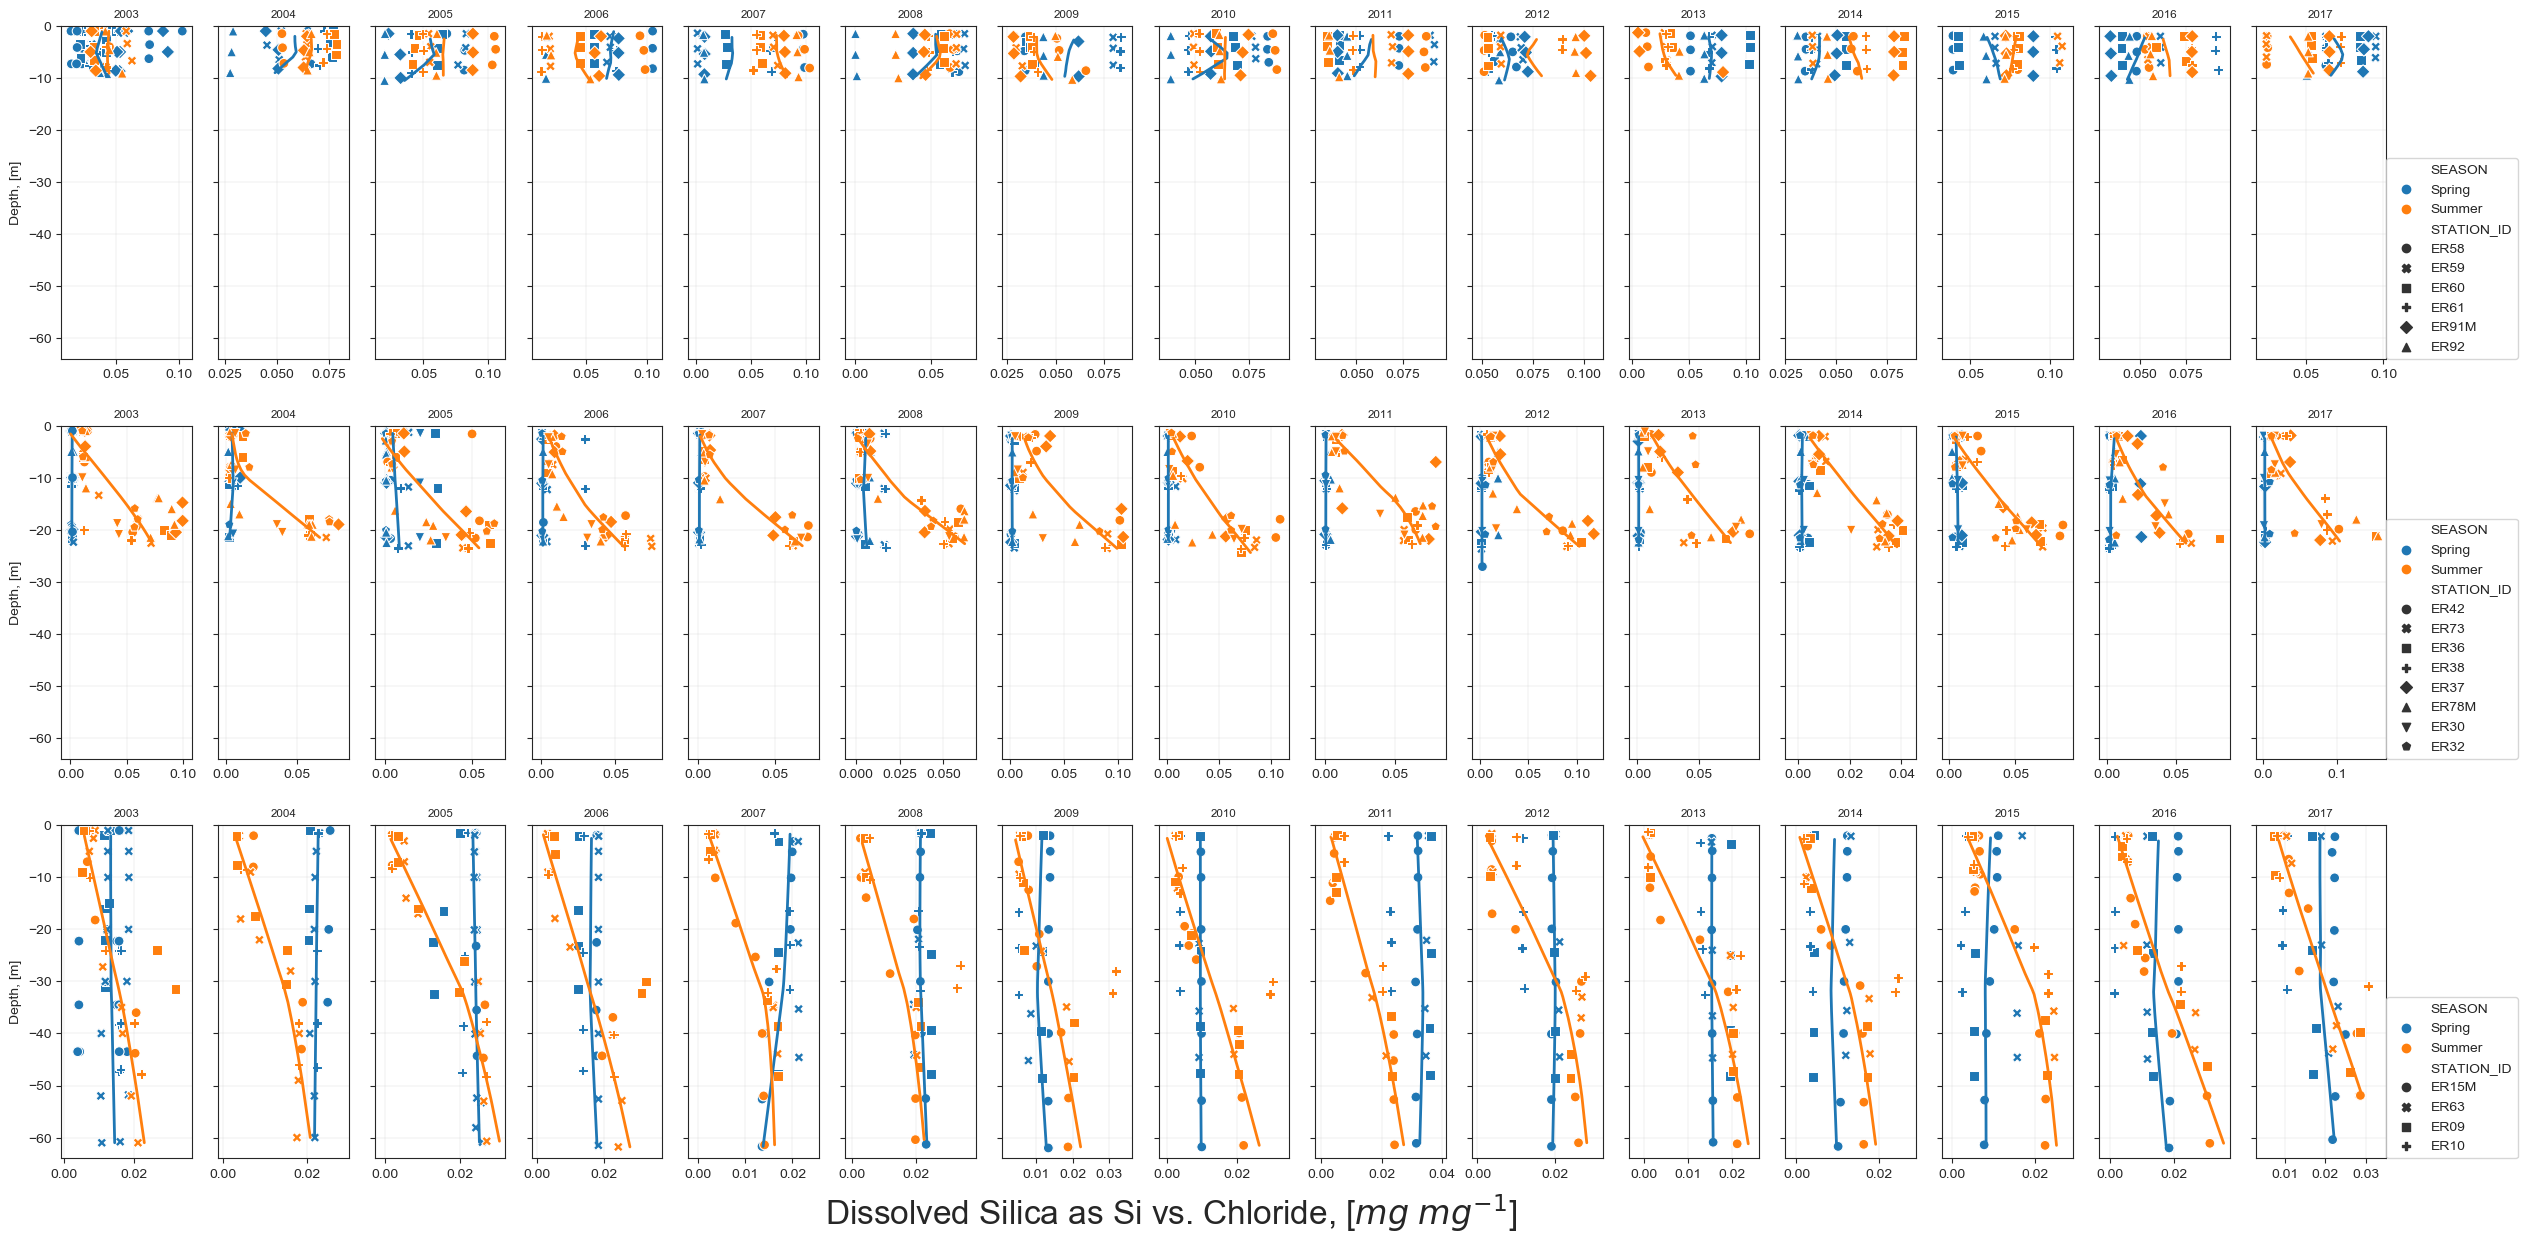

In [96]:

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = SilicaDissAsSiVsCl[(SilicaDissAsSiVsCl['STATION_ID'].isin(b)) & (SilicaDissAsSiVsCl['YEAR']==y)]
        sns.scatterplot(x='SilicaDissAsSiVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['SilicaDissAsSiVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['SilicaDissAsSiVsCl'].reset_index()['SilicaDissAsSiVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Dissolved Silica as Si vs. Chloride, [$m g$ $mg^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/SilicaDissAsSi_vs_Cl_no_scales.pdf')




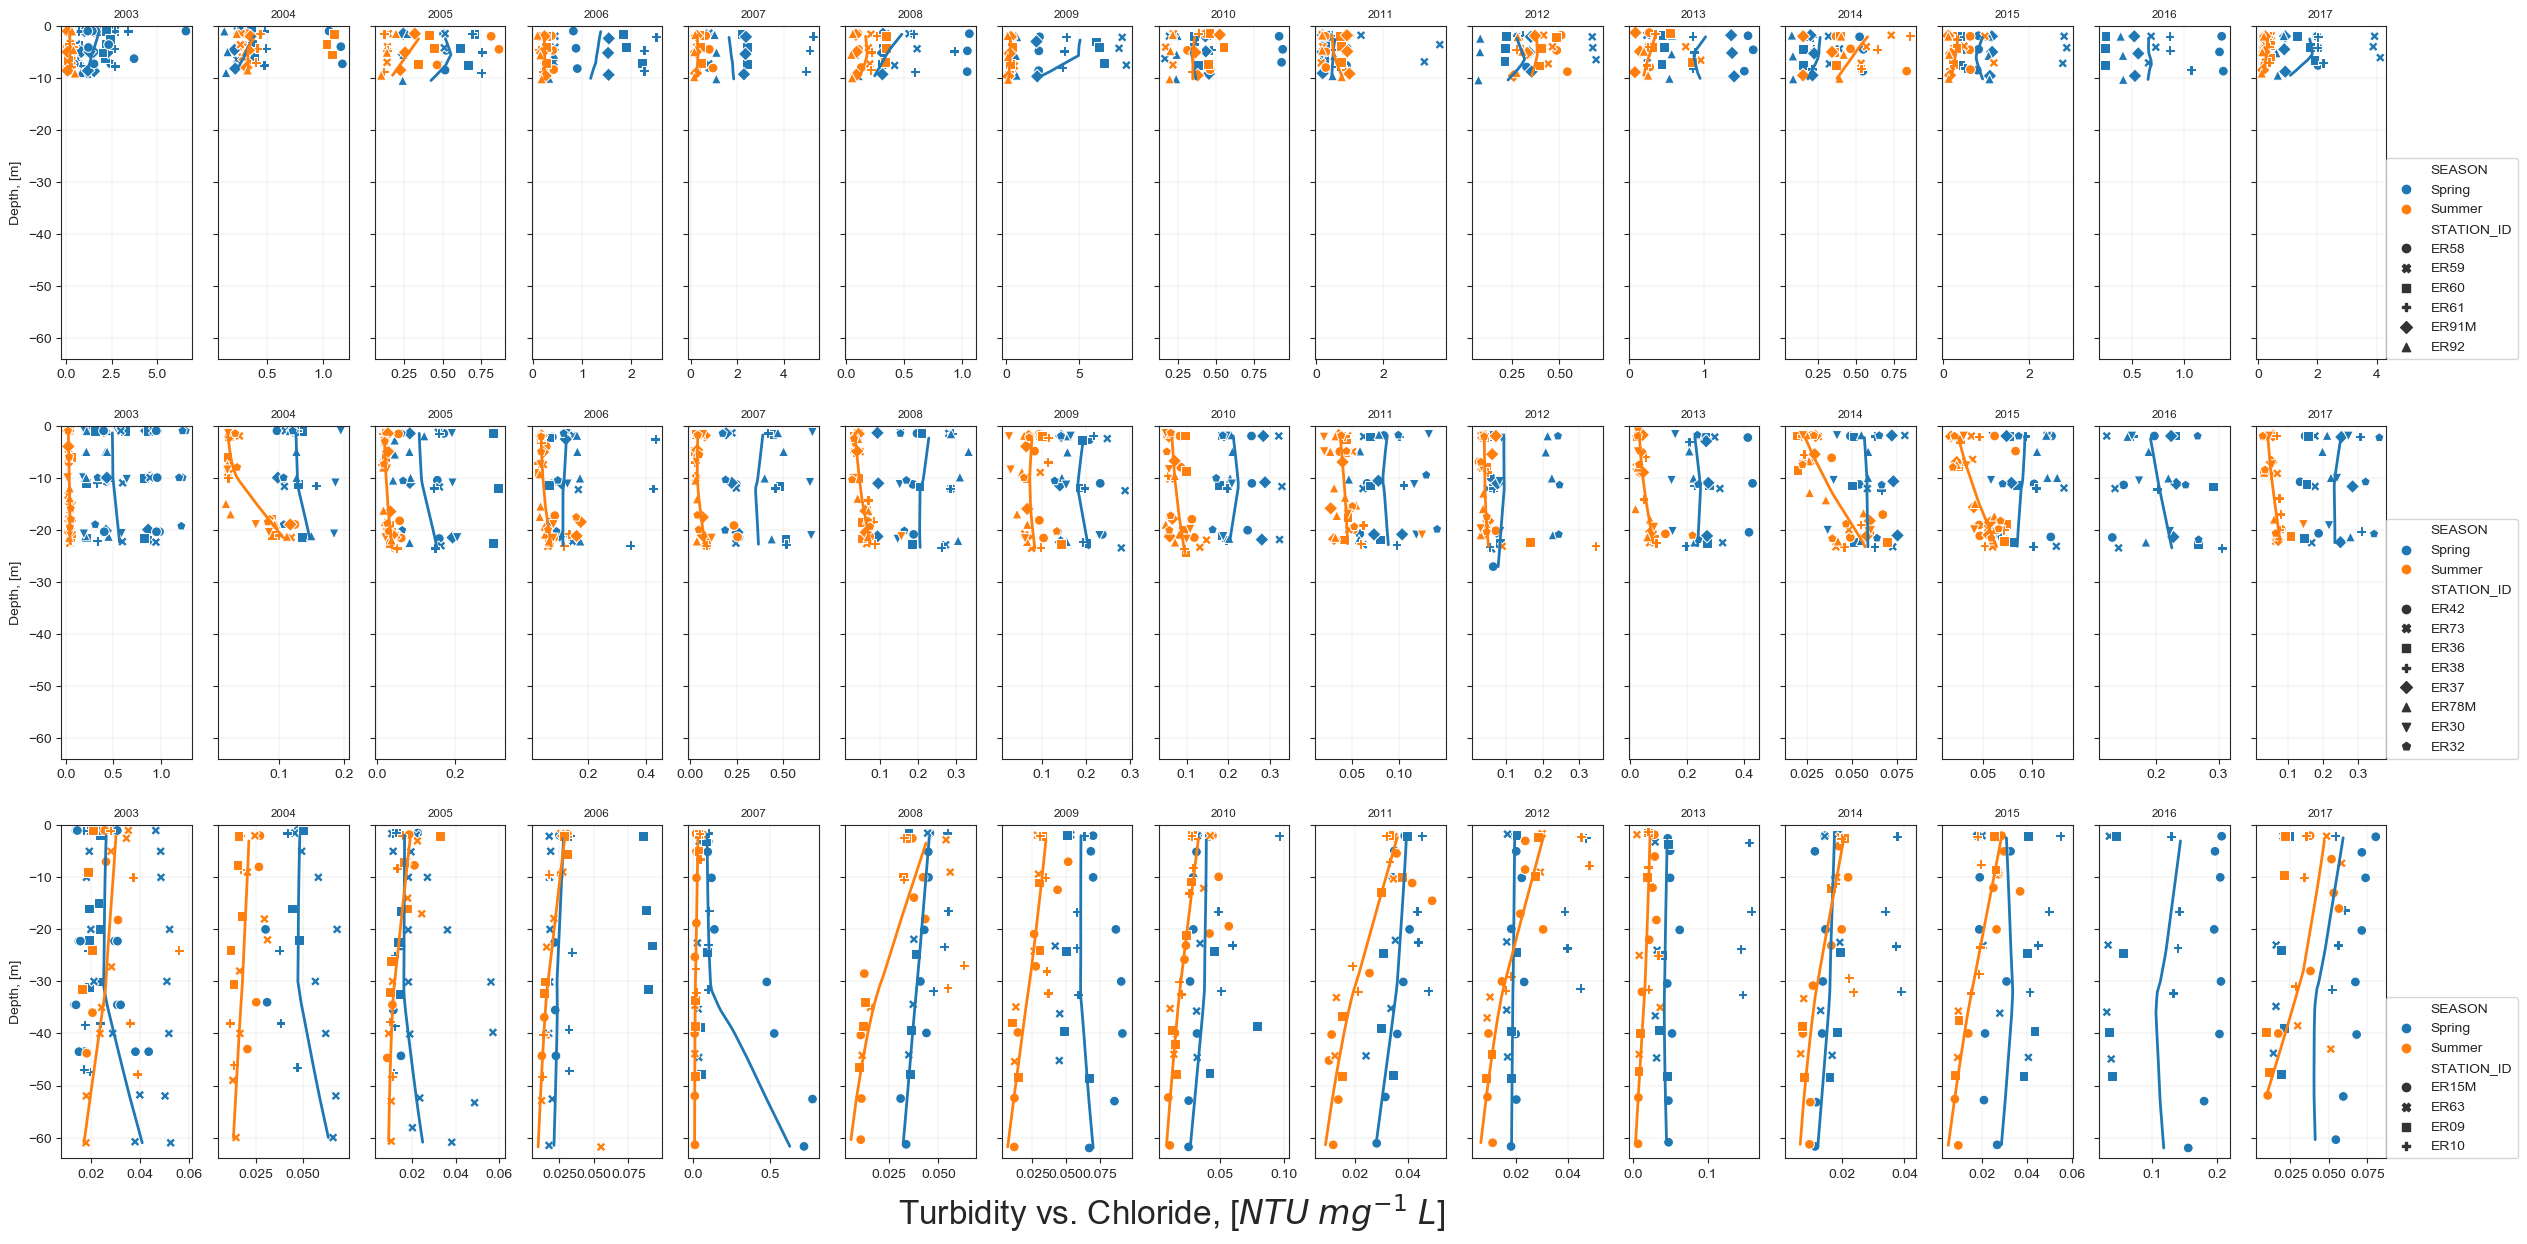

In [100]:
Turbidity = pd.read_csv('../../measurements/GLNPO/Mass Balance/Turbidity.csv')
Turbidity = Turbidity[Turbidity.QC_TYPE=='routine field sample']
Turbidity = Turbidity[~Turbidity.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Turbidity = Turbidity[Turbidity.YEAR>2002]
Turbidity.loc[:,'SAMPLE_DEPTH_M'] *= -1
Turbidity.round({'SAMPLE_DEPTH_M': 0})
Turbidity = Turbidity[Turbidity['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Turbidity = Turbidity[Turbidity['SEASON'].isin(seasons)]
Turbidity['Turbidity_conc'] = pd.to_numeric(Turbidity['VALUE_1'], errors='coerce')
# Turbidity = Turbidity[Turbidity['VALUE_1']>50]
# Turbidity = Turbidity.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
TurbidityVsCl = pd.merge(Cl, Turbidity, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
TurbidityVsCl['TurbidityVsCl'] = TurbidityVsCl['Turbidity_conc']/TurbidityVsCl['Cl_conc']
TurbidityVsCl.dropna(subset=['TurbidityVsCl'], inplace=True)

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = TurbidityVsCl[(TurbidityVsCl['STATION_ID'].isin(b)) & (TurbidityVsCl['YEAR']==y)]
        sns.scatterplot(x='TurbidityVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['TurbidityVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['TurbidityVsCl'].reset_index()['TurbidityVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Turbidity vs. Chloride, [$NTU$ $mg^{-1}$ $L$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Turbidity_vs_Cl_no_scales.pdf')




Text(8.5,-0.2,'Conductivity vs. Chloride, [$umho$ $cm^{-1}$ $mg^{-1}$ $L$]')

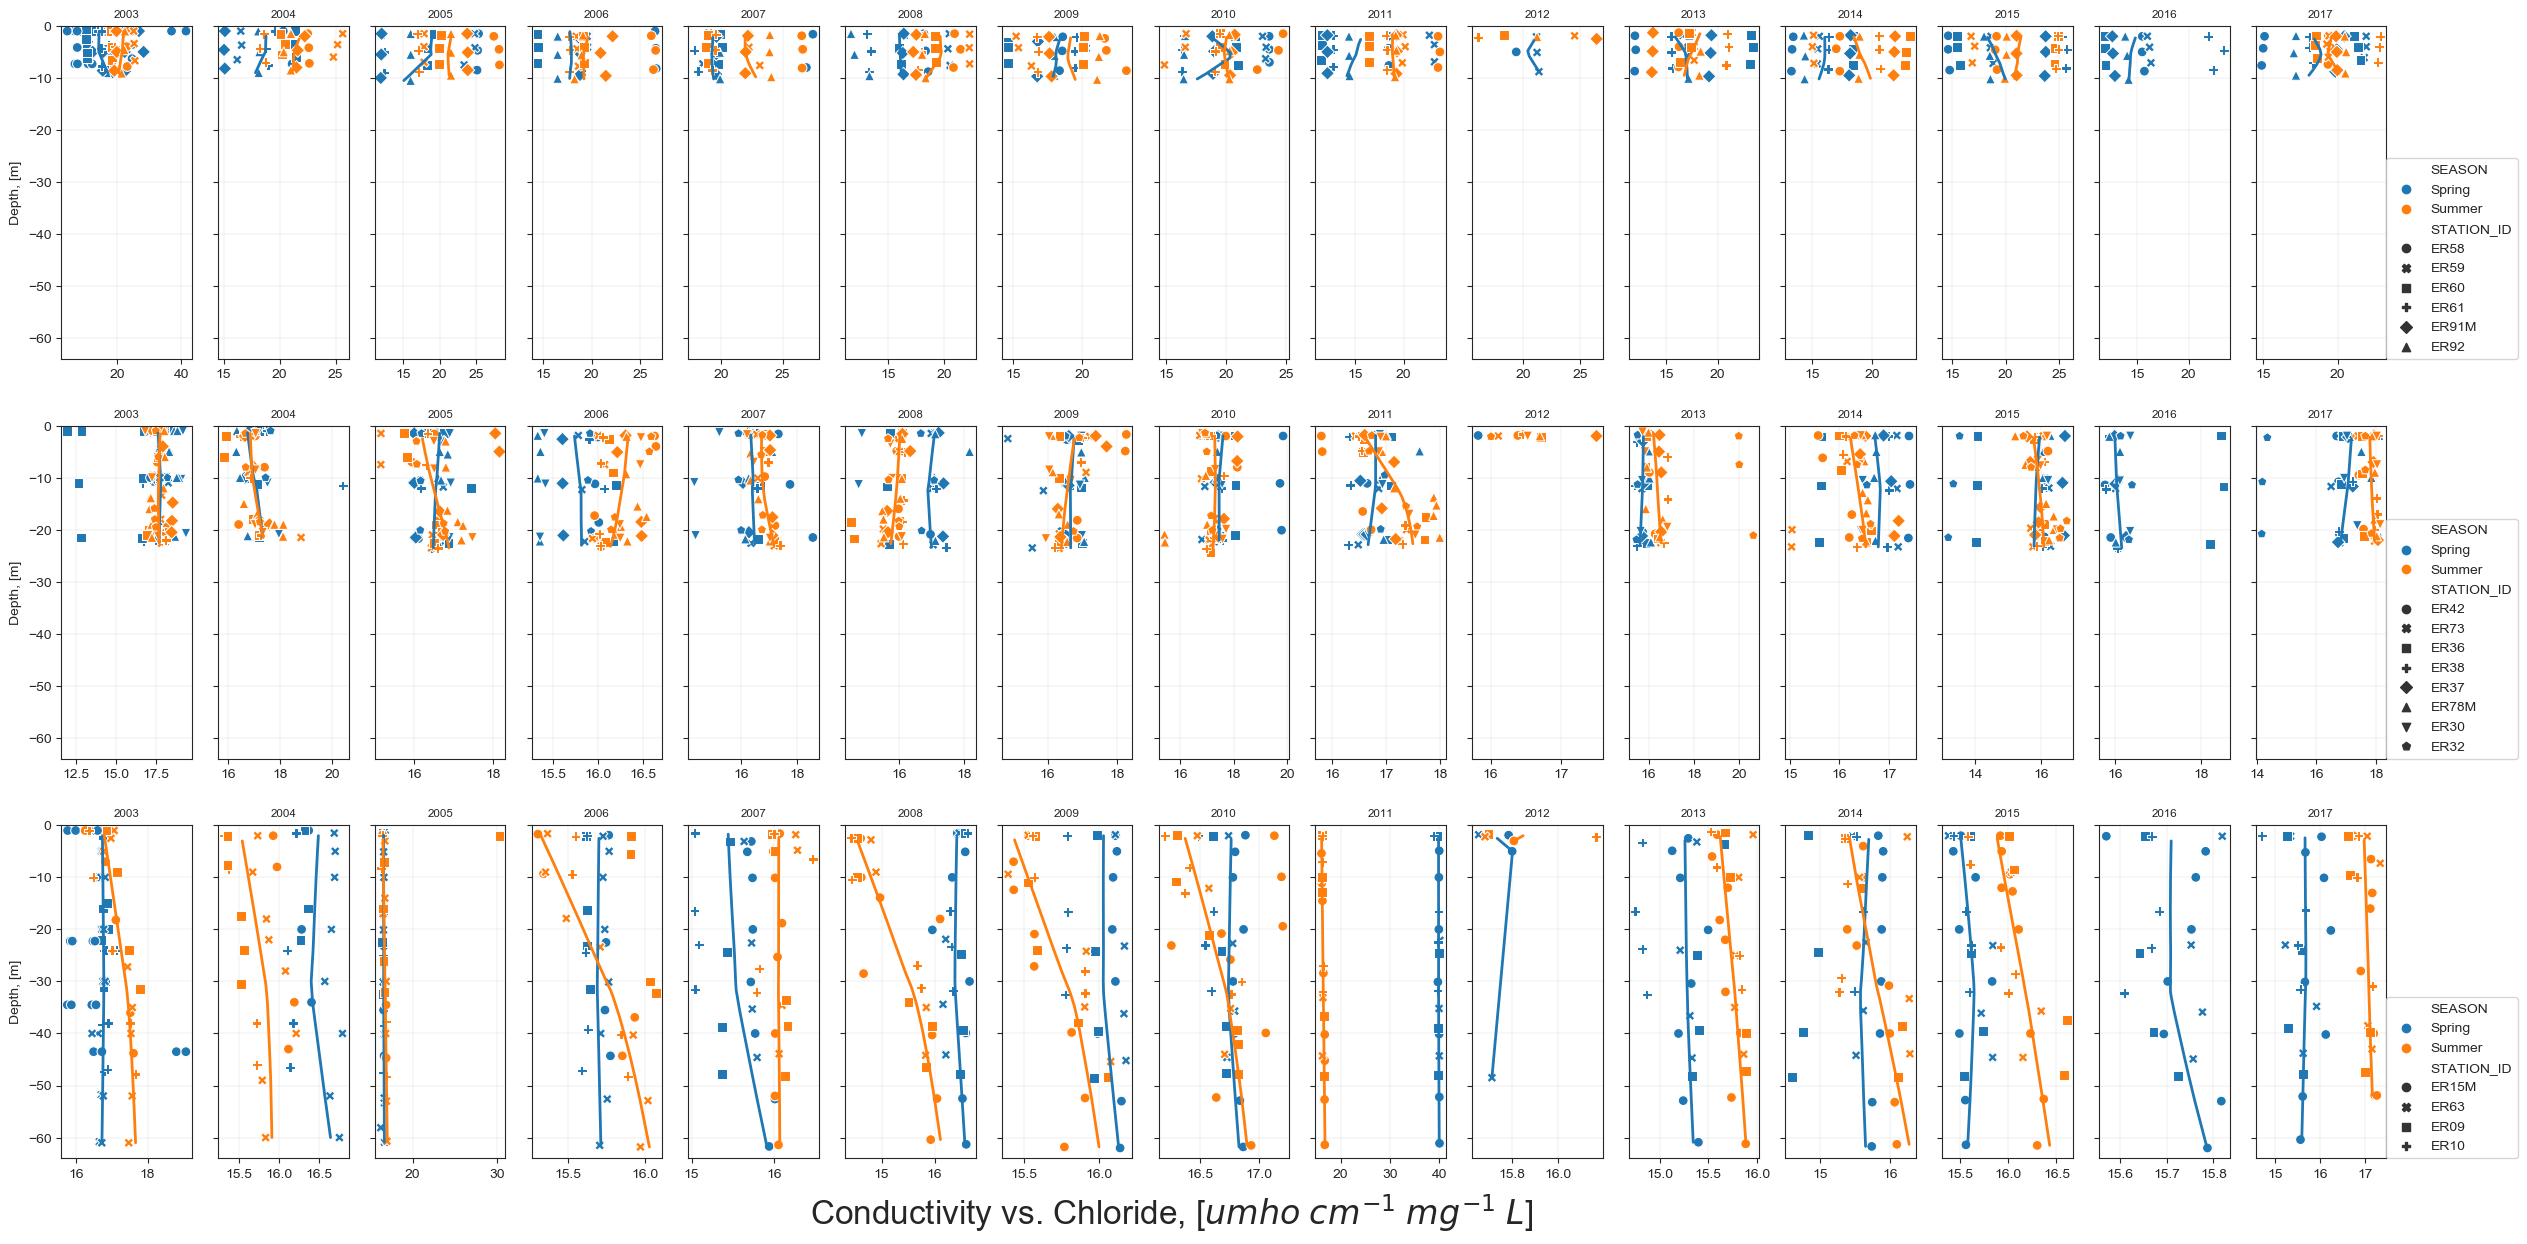

In [103]:
Conductivity = pd.read_csv('../../measurements/GLNPO/Mass Balance/Conductivity.csv')
Conductivity = Conductivity[Conductivity.QC_TYPE=='routine field sample']
Conductivity = Conductivity[~Conductivity.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Conductivity = Conductivity[Conductivity.YEAR>2002]
Conductivity.loc[:,'SAMPLE_DEPTH_M'] *= -1
Conductivity.round({'SAMPLE_DEPTH_M': 0})
Conductivity = Conductivity[Conductivity['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Conductivity = Conductivity[Conductivity['SEASON'].isin(seasons)]
Conductivity['Conductivity_conc'] = pd.to_numeric(Conductivity['VALUE_1'], errors='coerce')
# Conductivity = Conductivity[Conductivity['VALUE_1']>50]
# Conductivity = Conductivity.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
ConductivityVsCl = pd.merge(Cl, Conductivity, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
ConductivityVsCl['ConductivityVsCl'] = ConductivityVsCl['Conductivity_conc']/ConductivityVsCl['Cl_conc']
ConductivityVsCl.dropna(subset=['ConductivityVsCl'], inplace=True)

# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = ConductivityVsCl[(ConductivityVsCl['STATION_ID'].isin(b)) & (ConductivityVsCl['YEAR']==y)]
        sns.scatterplot(x='ConductivityVsCl', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['ConductivityVsCl'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['ConductivityVsCl'].reset_index()['ConductivityVsCl'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Conductivity vs. Chloride, [$umho$ $cm^{-1}$ $mg^{-1}$ $L$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Conductivity_vs_Cl.pdf')




In [104]:
orthoPVsTOTP = pd.merge(TOTP, orthoP, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
orthoPVsTOTP['orthoPVsTOTP'] = orthoPVsTOTP['orthoP_conc']/orthoPVsTOTP['TOTP_conc']
orthoPVsTOTP.dropna(subset=['orthoPVsTOTP'], inplace=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Text(8.5,-0.2,'Inorg. P vs. TOTP, [$\\mu g$ $\\mu g^{-1}$]')

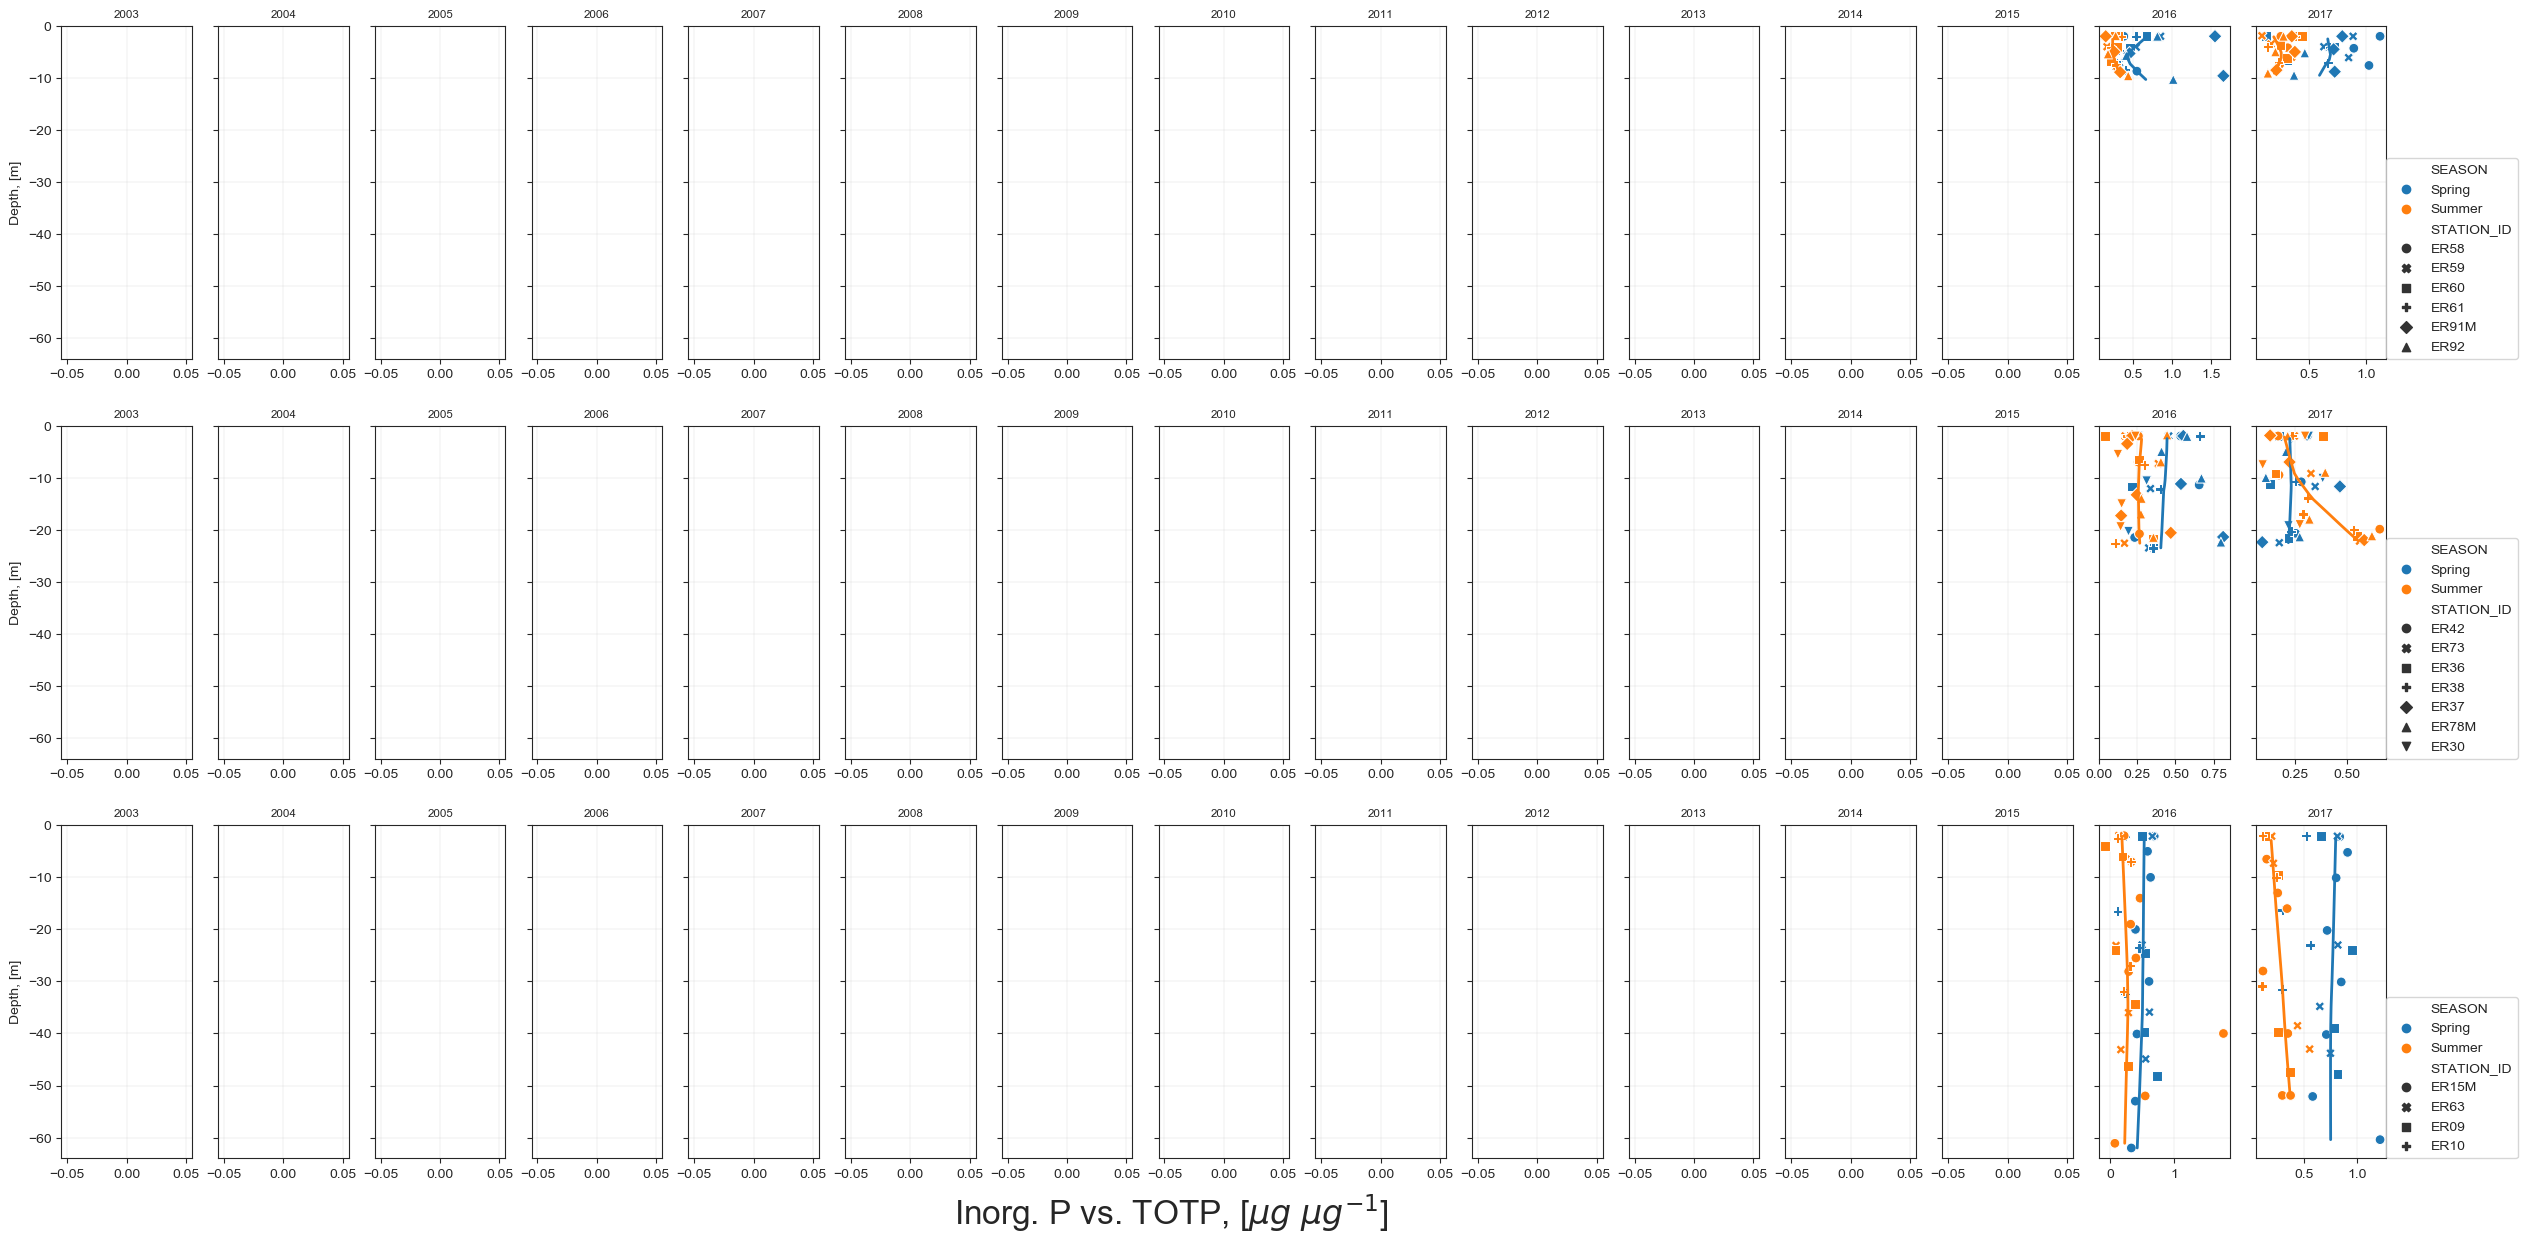

In [106]:
# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = orthoPVsTOTP[(orthoPVsTOTP['STATION_ID'].isin(b)) & (orthoPVsTOTP['YEAR']==y)]
        sns.scatterplot(x='orthoPVsTOTP', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['orthoPVsTOTP'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['orthoPVsTOTP'].reset_index()['orthoPVsTOTP'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Inorg. P vs. TOTP, [$\mu g$ $\mu g^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/iP_vs_TOTP.pdf')




No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(8.5,-0.2,'Chl-a vs. TOTP, [$\\mu g$ $\\mu g^{-1}$]')

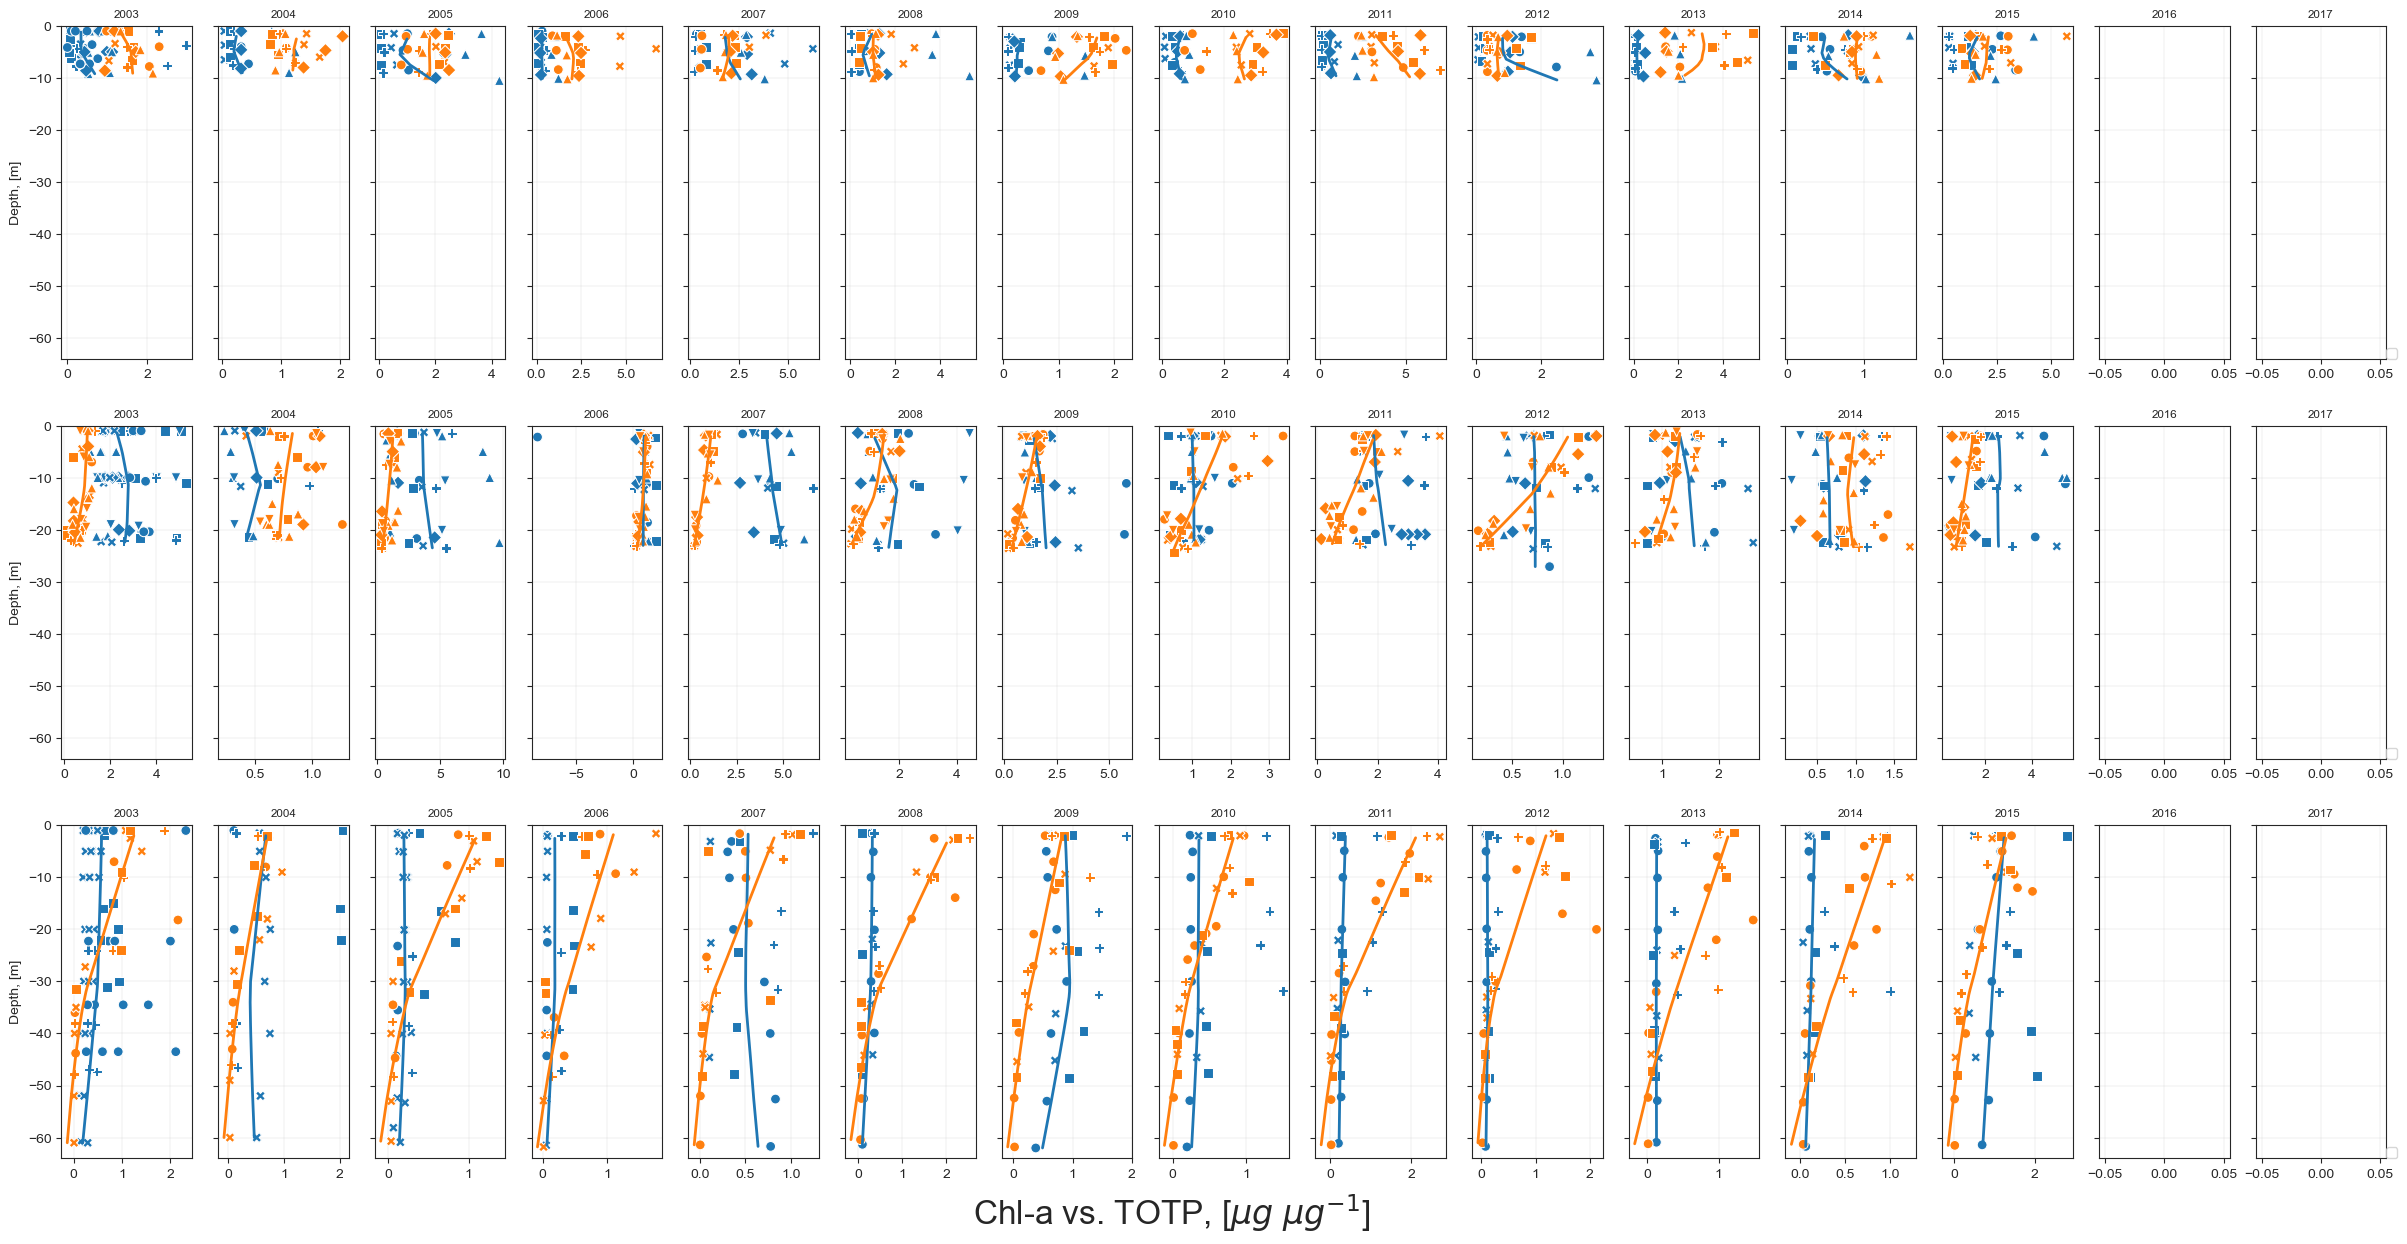

In [117]:
ChlaVsTOTP = pd.merge(TOTP, Chla, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
ChlaVsTOTP['ChlaVsTOTP'] = ChlaVsTOTP['Chla_conc']/ChlaVsTOTP['TOTP_conc']
ChlaVsTOTP.dropna(subset=['ChlaVsTOTP'], inplace=True)
# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = ChlaVsTOTP[(ChlaVsTOTP['STATION_ID'].isin(b)) & (ChlaVsTOTP['YEAR']==y)]
        sns.scatterplot(x='ChlaVsTOTP', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsTOTP'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsTOTP'].reset_index()['ChlaVsTOTP'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Chl-a vs. TOTP, [$\mu g$ $\mu g^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Chla_vs_TOTP.pdf')




No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


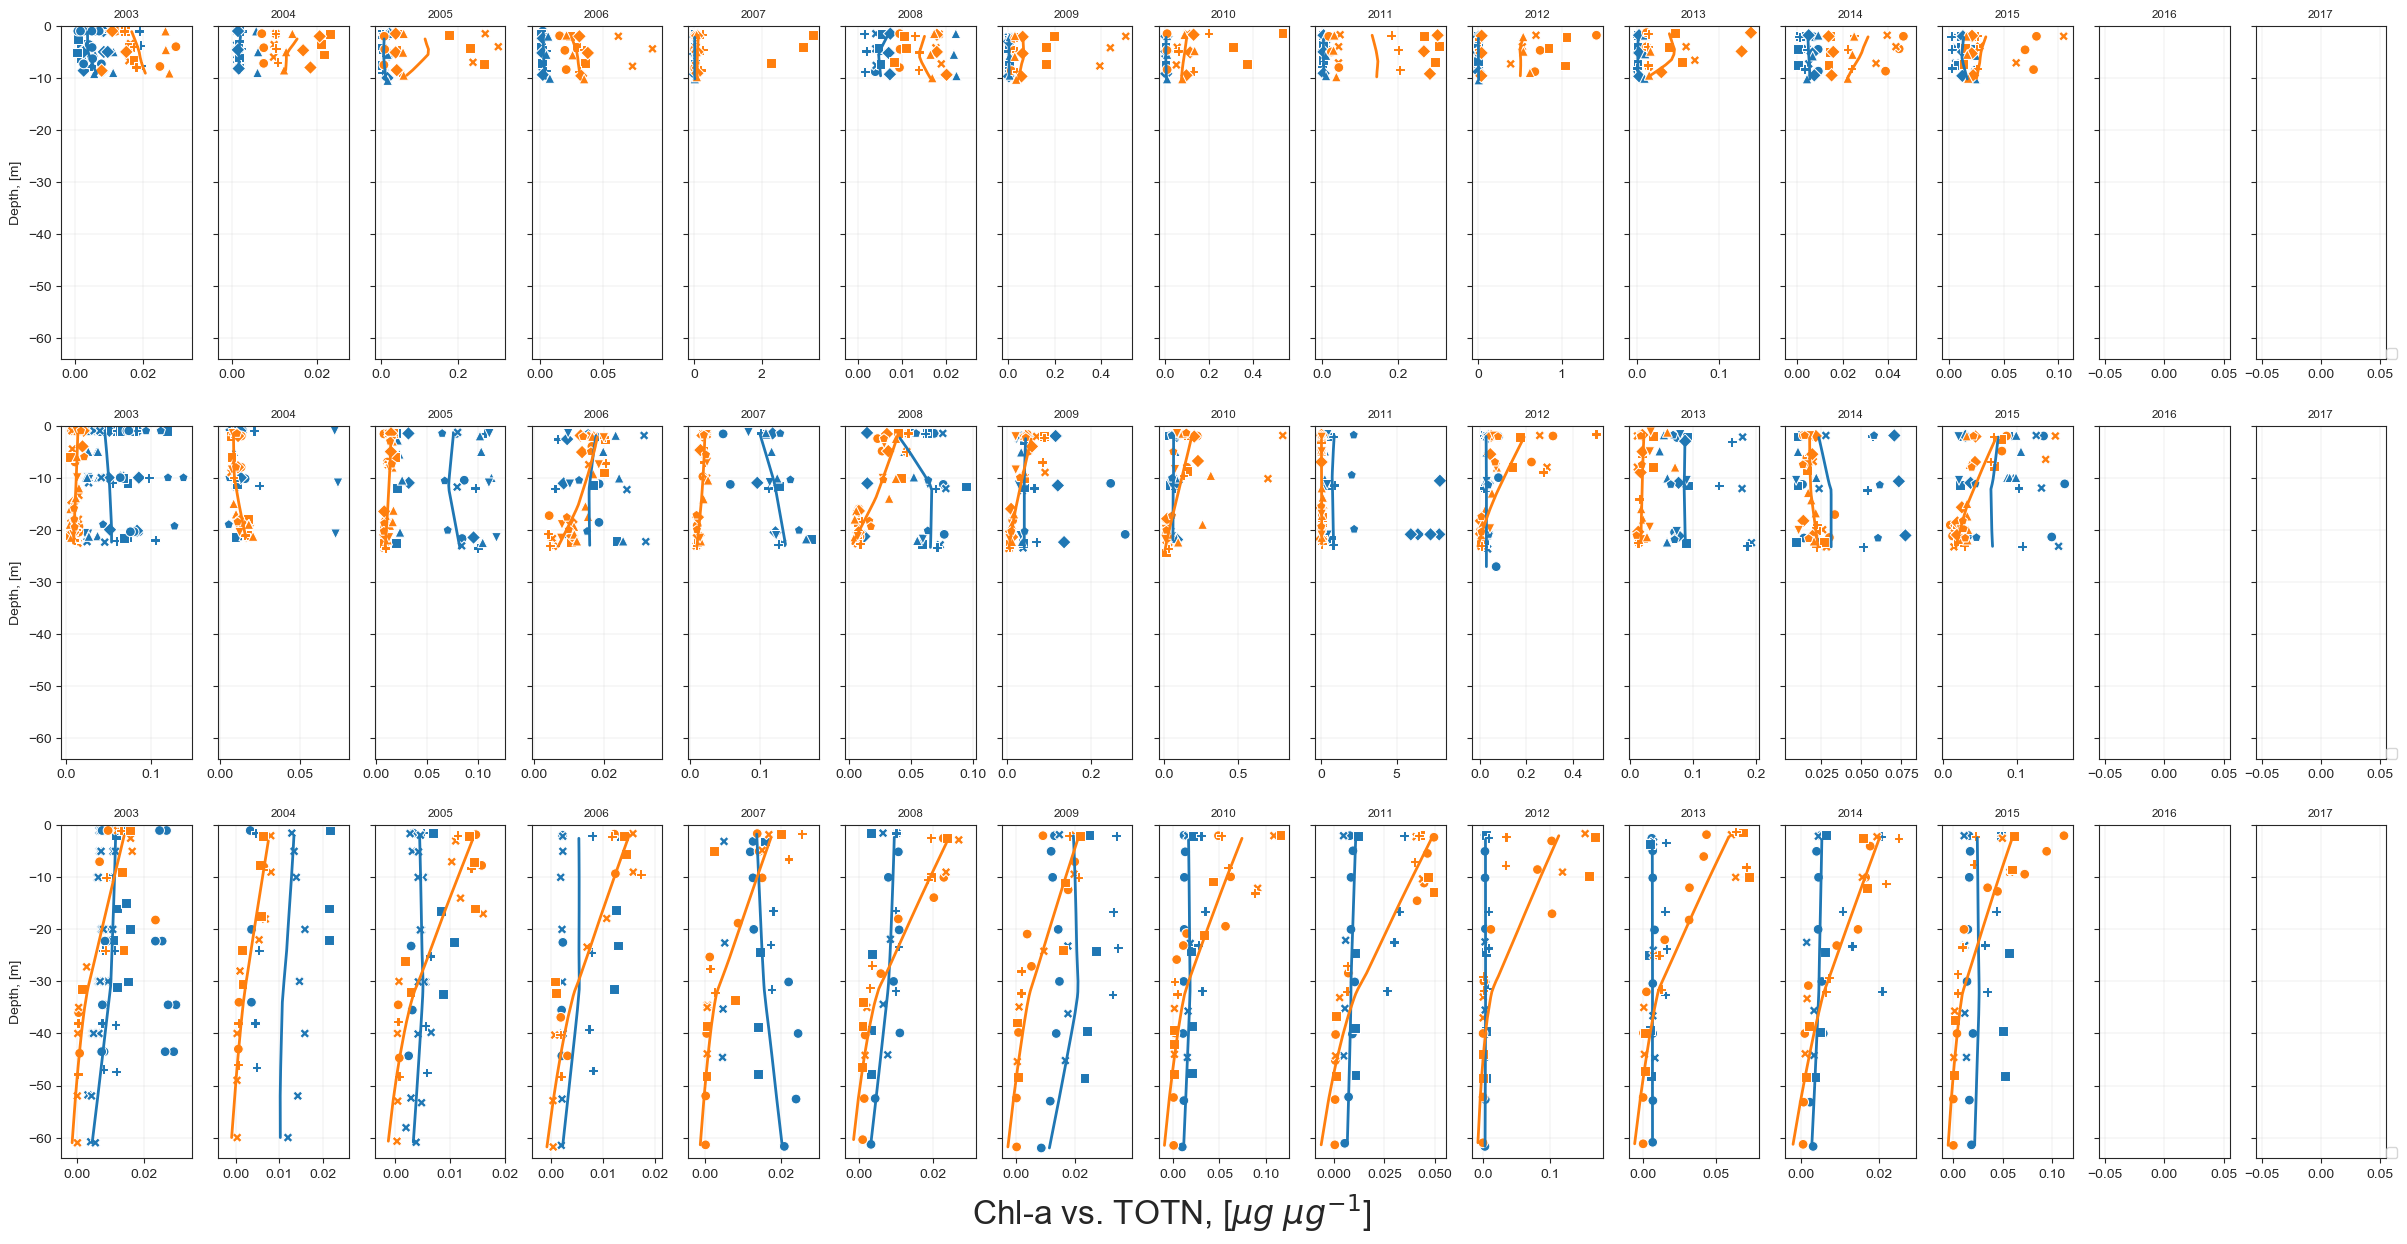

In [137]:
ChlaVsNtot_oxidized = pd.merge(Chla, Ntot_oxidized, how='left', on=['SAMPLE_DEPTH_M', 'STATION_ID', 'SEASON', 'YEAR', 'SAMPLE_DEPTH_M'])
ChlaVsNtot_oxidized['ChlaVsNtot_oxidized'] = ChlaVsNtot_oxidized['Chla_conc']/ChlaVsNtot_oxidized['Ntot_oxidized_conc']/1000
# ChlaVsNtot_oxidized.dropna(subset=['ChlaVsNtot_oxidized'], inplace=True)
# ChlaVsNtot_oxidized['ChlaVsNtot_oxidized'] = ChlaVsNtot_oxidized[ChlaVsNtot_oxidized['ChlaVsNtot_oxidized']>0]
# %matplotlib osx

f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = ChlaVsNtot_oxidized[(ChlaVsNtot_oxidized['STATION_ID'].isin(b)) & (ChlaVsNtot_oxidized['YEAR']==y)]
        sns.scatterplot(x='ChlaVsNtot_oxidized', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsNtot_oxidized'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['ChlaVsNtot_oxidized'].reset_index()['ChlaVsNtot_oxidized'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]
    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((min(low), max(high)))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Chl-a vs. TOTN, [$\mu g$ $\mu g^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Chla_vs_Ntot_oxidized_no_scales.pdf')


